In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import scienceplots
import networkx as nx
import ast

from nanonets import Simulation
from nanonets.utils import extract_harmonic_features, BLUE_COLOR, RED_COLOR, get_displacement_currents, get_tau_f0_SET
from matplotlib.animation import FuncAnimation
from matplotlib.colors import Normalize
from matplotlib.cm import ScalarMappable
from scipy.signal import correlate2d, correlate
from scipy.optimize import curve_fit
from scipy.linalg import eig
from mpl_toolkits.axes_grid1.inset_locator import inset_axes


plt.style.use(["science","bright","grid"])
# PATH = "/home/jonasmensing/bagheera/data/2_funding_period/dynamic/AC/amp_freq_size_final/short/"
# PATH = "/home/j/j_mens07/bagheera/data/2_funding_period/dynamic/AC/regular/freq_edge/"
# PATH = "/home/jonasmensing/bagheera/data/2_funding_period/dynamic/AC/regular/freq_edge/"
# PATH = "/home/jonas/bagheera/data/2_funding_period/dynamic/AC/regular/freq_edge/"
# PATH = "/home/jonasmensing/bagheera/data/2_funding_period/dynamic/AC/regular/freq_edge/"
PATH = "/home/j/j_mens07/bagheera/data/2_funding_period/dynamic/AC/regular/freq_edge/"

def get_lattice_electrode_cap_matrix(L: int):
    topo = {"Nx": L,"Ny": L,
            "e_pos": [[(L-1)//2, 0],[0, 0],[L-1, 0],
                    [0, (L-1)//2],[L-1, (L-1)//2],
                    [0, L-1],[L-1, L-1],[(L-1)//2, L-1]],
            "electrode_type": ['constant']*8}
    sim  = Simulation(topo)
    return sim.get_electrode_capacitance_matrix()

def get_capacitance_matrix(L: int):
    topo = {"Nx": L,"Ny": L,
            "e_pos": [[(L-1)//2, 0],[0, 0],[L-1, 0],
                    [0, (L-1)//2],[L-1, (L-1)//2],
                    [0, L-1],[L-1, L-1],[(L-1)//2, L-1]],
            "electrode_type": ['constant']*8}
    sim  = Simulation(topo)
    return sim.get_capacitance_matrix()

def get_network_topology(L: int):
    topo = {"Nx": L,"Ny": L,
            "e_pos": [[(L-1)//2, 0],[0, 0],[L-1, 0],
                    [0, (L-1)//2],[L-1, (L-1)//2],
                    [0, L-1],[L-1, L-1],[(L-1)//2, L-1]],
            "electrode_type": ['constant']*8}
    sim  = Simulation(topo)
    return sim.get_net_topology()

In [19]:
# PARAMETER
# N_PARTICLES     = [3,5,7,9,11,13,15]
# N_PARTICLES     = [3,5,7,9,11,13,15]
N_PARTICLES     = [3,5,7,9,11,13,15]
AMPLITUDE_LIST  = {3: 0.0307, 4: 0.0344, 5: 0.0364, 6: 0.0377, 7: 0.0386, 8: 0.0393,
                   9: 0.0398, 10: 0.0401, 11: 0.0405, 12: 0.0407, 13: 0.0409, 14: 0.0411, 15: 0.0412}
# AMPLITUDE_LIST  = {3   : 0.0146, 5   : 0.0271, 7   : 0.0374, 9   : 0.0327, 11  : 0.0366, 13  : 0.0436, 15  : 0.0478}
# AMPLITUDE_LIST  = {3: 0.0299, 4: 0.0323, 5: 0.0326, 6: 0.0328, 7: 0.0328, 8: 0.0328, 9: 0.0327,
#                    10: 0.0327, 11: 0.0326, 12: 0.0326, 13: 0.0325, 14: 0.0325, 15: 0.0324}
FREQ_LIST_MHZ   = [0.005,0.01,0.03,0.06,0.12,0.25,0.5,1.,2.,5.,6.,8.,
                   10.,12.,15.,18.,23.,28.,36.,44.,55.,68.,86.,105.,133.,266.,610.,1200.]
N_PERIODS       = 100
N_SKIP          = 80
SAMPLE_P_PERIOD = 40
N_ELECTRODES    = 8
N_NP            = 9
PLOT_SIZE_NORM  = Normalize(vmin=N_PARTICLES[0]**2, vmax=N_PARTICLES[-1]**2)
C_US            = {N : get_lattice_electrode_cap_matrix(N).T for N in N_PARTICLES}
C_MAT           = {N : get_capacitance_matrix(N) for N in N_PARTICLES}
TAU_SET, F0_SET = get_tau_f0_SET()

### Load Data

In [20]:
dts     = {freq : 1/(40 * freq * 1e6) for freq in FREQ_LIST_MHZ}
N_steps = {freq : int(np.ceil((N_PERIODS / (freq * 1e6)) / dts[freq])) for freq in FREQ_LIST_MHZ}
time    = {freq : dts[freq]*np.arange(N_steps[freq]) for freq in FREQ_LIST_MHZ}
data    = {N : {freq : pd.read_csv(f"{PATH}Nx={N}_Ny={N}_Ne=8_{freq:.3f}_{AMPLITUDE_LIST[N]:.4f}.csv") for freq in FREQ_LIST_MHZ} for N in N_PARTICLES}
states  = {N : {freq : pd.read_csv(f"{PATH}mean_state_Nx={N}_Ny={N}_Ne=8_{freq:.3f}_{AMPLITUDE_LIST[N]:.4f}.csv") for freq in FREQ_LIST_MHZ} for N in N_PARTICLES}

In [5]:
x   = {N : {freq : data[N][freq]['E0'].values[N_SKIP*SAMPLE_P_PERIOD:].copy() for freq in FREQ_LIST_MHZ} for N in N_PARTICLES}
y_t = {N : {freq : data[N][freq]['Observable'].values[N_SKIP*SAMPLE_P_PERIOD:].copy() for freq in FREQ_LIST_MHZ} for N in N_PARTICLES}
y_e = {N : {freq : data[N][freq]['Error'].values[N_SKIP*SAMPLE_P_PERIOD:].copy() for freq in FREQ_LIST_MHZ} for N in N_PARTICLES}
p   = {N : {freq : states[N][freq].iloc[:,8:].values[N_SKIP*SAMPLE_P_PERIOD:].copy() for freq in FREQ_LIST_MHZ} for N in N_PARTICLES}
p_m = {N : {freq : np.mean(states[N][freq].iloc[:,8:].values, axis=1)[N_SKIP*SAMPLE_P_PERIOD:].copy() for freq in FREQ_LIST_MHZ} for N in N_PARTICLES}
y_d = {N : {freq : get_displacement_currents(p[N][freq], C_US[N], dts[freq]) for freq in FREQ_LIST_MHZ} for N in N_PARTICLES}
y   = {N : {freq : y_t[N][freq]+y_d[N][freq] for freq in FREQ_LIST_MHZ} for N in N_PARTICLES}

### Device Transconductance

In [6]:
y_rms   = {N : np.array([np.std(y[N][f0]) for f0 in FREQ_LIST_MHZ]) for N in N_PARTICLES}
trans_I = {N : y_rms[N]*1e-6/AMPLITUDE_LIST[N] for N in N_PARTICLES}
gain_I  = {N : 20*np.log10(y_rms[N]/y_rms[N][0]) for N in N_PARTICLES}

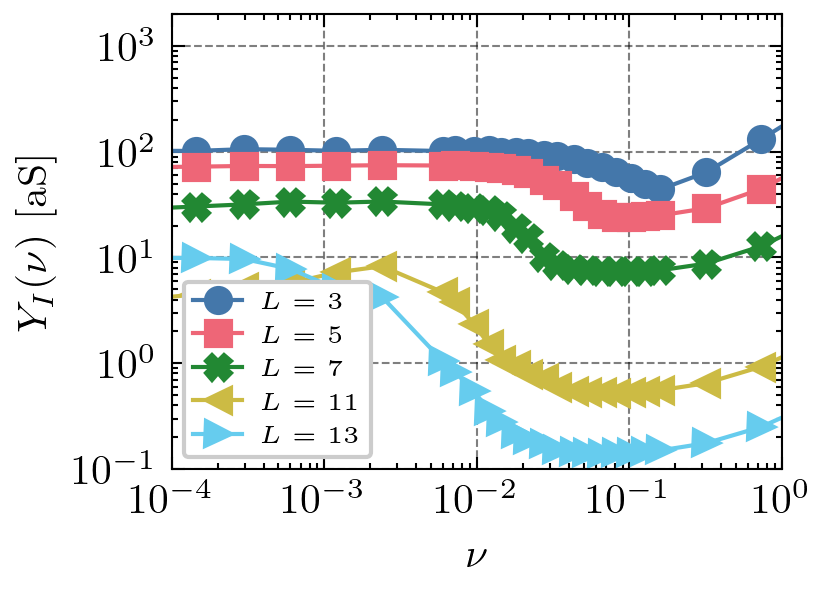

In [7]:
cmap    = plt.get_cmap('cividis')
marker  = ['o','s','X','<','>','^','v']
fig     = plt.figure(dpi=300)
ax      = fig.add_subplot()
w, h    = fig.get_size_inches()
scale   = 0.75
fig.set_size_inches(w * scale, h * scale)

for i, N in enumerate(N_PARTICLES):
    # ax.errorbar(np.array(FREQ_LIST_MHZ)/F0_SET, np.mean(gain_I[N],axis=1).flatten(), 1.96*np.std(gain_I[N],axis=1).flatten(),
    #             marker=marker[i], label=rf'$L = {N}$', capsize=2)
    ax.plot(np.array(FREQ_LIST_MHZ)/F0_SET, trans_I[N], marker=marker[i], label=rf'$L = {N}$')
_ = ax.set_xscale('log')
_ = ax.set_xlabel("$\\nu$")
_ = ax.set_ylabel("$Y_{I}(\\nu)$ [aS]")
_ = ax.set_xlim(1e-4,1e0)
_ = ax.set_ylim(1e-1,2e3)
_ = ax.set_yscale('log')
_ = ax.legend(fontsize='xx-small', loc='lower left', ncol=1)

# fig.savefig(f"plots/pdf/I_transconductance_vs_f0.pdf", transparent=False)
# fig.savefig(f"plots/svg/I_transconductance_vs_f0.svg", transparent=True)
# fig.savefig(f"plots/png/I_transconductance_vs_f0.png", transparent=False)

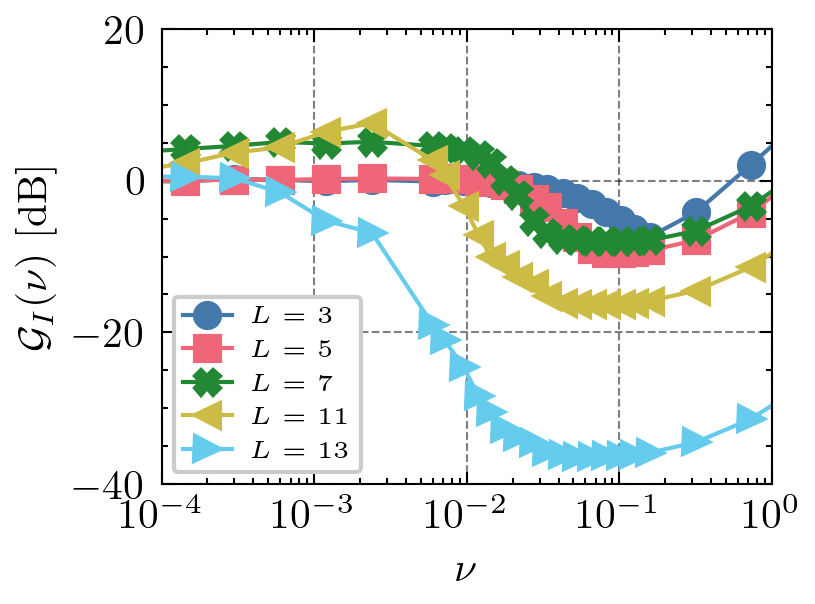

In [18]:
cmap    = plt.get_cmap('cividis')
marker  = ['o','s','X','<','>','^','v']
fig     = plt.figure(dpi=300)
ax      = fig.add_subplot()
w, h    = fig.get_size_inches()
scale   = 0.75
fig.set_size_inches(w * scale, h * scale)

for i, N in enumerate(N_PARTICLES):
    # ax.errorbar(np.array(FREQ_LIST_MHZ)/F0_SET, np.mean(gain_I[N],axis=1).flatten(), 1.96*np.std(gain_I[N],axis=1).flatten(),
    #             marker=marker[i], label=rf'$L = {N}$', capsize=2)
    ax.plot(np.array(FREQ_LIST_MHZ)/F0_SET, gain_I[N], marker=marker[i], label=rf'$L = {N}$')
_ = ax.set_xscale('log')
_ = ax.set_xlabel("$\\nu$")
_ = ax.set_ylabel("$\\mathcal{G}_{I}(\\nu)$ [dB]")
_ = ax.set_xlim(1e-4,1e0)
_ = ax.set_ylim(-40,20)
# _ = ax.set_yscale('log')
_ = ax.legend(fontsize='xx-small', loc='lower left', ncol=1)

# fig.savefig(f"plots/pdf/I_DC_AC_gain_vs_f0.pdf", transparent=False)
# fig.savefig(f"plots/svg/I_DC_AC_gain_vs_f0.svg", transparent=True)
# fig.savefig(f"plots/png/I_DC_AC_gain_vs_f0.png", transparent=False)

### Phase difference

In [11]:
def get_phase_lag(response_signal: np.ndarray, input_signal: np.ndarray) -> float:
    """
    Calculates the Phase Lag between a system response and the driving input 
    at the fundamental driving frequencyme-domain snippet (maybe 3 or 4 AC cycles) of the raw Observable Tunneling Current (yt) side-by-side f
        Range is normalized to [-180, 180]. 
        Negative values indicate the response 'lags' behind the input (Capacitive).
        Positive values indicate the response 'leads' the input (Inductive).
    """
    
    # 1. Apply Windowing (Optional but recommended to reduce spectral leakage)
    # If your signal is an exact integer number of periods, you can skip this.
    # Otherwise, a Hanning window helps.
    # window = np.hanning(len(response_signal))
    # resp_w = response_signal * window
    # input_w = input_signal * window

    resp_w  = response_signal
    input_w  = input_signal
    
    # 2. Compute FFT
    # We use rfft because the signals are real-valued
    fft_resp = np.fft.rfft(resp_w)
    fft_in = np.fft.rfft(input_w)
    
    # 3. Find the Fundamental Frequency Index
    # We assume the input is a dominant sine wave, so we just find the max peak.
    # We skip index 0 (DC component).
    idx_fund = np.argmax(np.abs(fft_in[1:])) + 1
    
    # 4. Extract Angles (Phases) at that index
    angle_resp = np.angle(fft_resp[idx_fund])
    angle_in = np.angle(fft_in[idx_fund])
    
    # 5. Calculate Difference
    phase_diff = angle_resp - angle_in
        
    # 7. Normalize to [-180, 180] range
    # This handles wrap-around (e.g., if result is -270, it becomes +90)
    phase_diff = (phase_diff + np.pi) % (2 * np.pi) - np.pi
    
    return phase_diff / np.pi

In [12]:
phase_s     = {N : [get_phase_lag(p_m[N][freq],x[N][freq]) for freq in FREQ_LIST_MHZ] for N in N_PARTICLES}
phase_I     = {N : [get_phase_lag(y[N][freq],x[N][freq]) for freq in FREQ_LIST_MHZ] for N in N_PARTICLES}
phase_I_t   = {N : [get_phase_lag(y_t[N][freq],x[N][freq]) for freq in FREQ_LIST_MHZ] for N in N_PARTICLES}
phase_I_d   = {N : [get_phase_lag(y_d[N][freq],x[N][freq]) for freq in FREQ_LIST_MHZ] for N in N_PARTICLES}

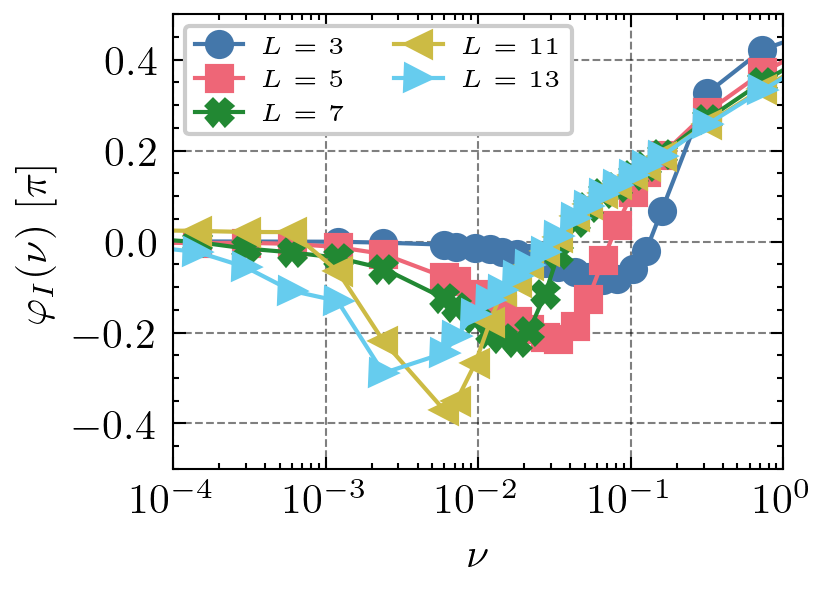

In [13]:
fig     = plt.figure(dpi=300)
ax      = fig.add_subplot()
w, h    = fig.get_size_inches()
scale   = 0.75
fig.set_size_inches(w * scale, h * scale)
for i, N in enumerate(N_PARTICLES):
    _   = ax.plot(np.array(FREQ_LIST_MHZ)/F0_SET, phase_I[N], marker=marker[i], label=rf'$L = {N}$')

_ = ax.set_xscale('log')
_ = ax.set_xlabel("$\\nu$")
_ = ax.set_ylabel("$\\varphi_{I}(\\nu)~[\mathrm{\pi}]$")
_ = ax.legend(fontsize='xx-small', loc='upper left', ncol=2)
_ = ax.set_ylim(-0.5,0.5)
_ = ax.set_xlim(1e-4,1e0)

fig.savefig(f"plots/pdf/I_f0_phase_scaling.pdf", transparent=False)
fig.savefig(f"plots/svg/I_f0_phase_scaling.svg", transparent=True)
fig.savefig(f"plots/png/I_f0_phase_scaling.png", transparent=False)

### Nonlinearity

In [14]:
def compute_thd(amplitudes):
    """
    Calculates Total Harmonic Distortion (THD).
    Input: Array of amplitudes [A_fund, A_harm1, A_harm2, ...]
    """
    if len(amplitudes) < 2 or amplitudes[0] == 0:
        return 0.0
        
    power_fund = amplitudes[0]**2
    power_harm = np.sum(amplitudes[1:]**2)
    
    return np.sqrt(power_harm) / np.sqrt(power_fund)

In [15]:
n_vals   = [1,3,5,7,9]
n_boot   = 200
# thd_vals = {N : [[compute_thd(extract_harmonic_features(y[N][freq]+np.random.normal(0,y_e[N][freq]/1.96),
#                                                         n_vals,mode='abs',pad_len=4096)) for _ in range(n_boot)] 
#                                                         for freq in FREQ_LIST_MHZ] for N in N_PARTICLES}
thd_vals = {N : [compute_thd(extract_harmonic_features(y[N][freq], n_vals, mode='abs', pad_len=4096, interpolate=True)) for freq in FREQ_LIST_MHZ] for N in N_PARTICLES}

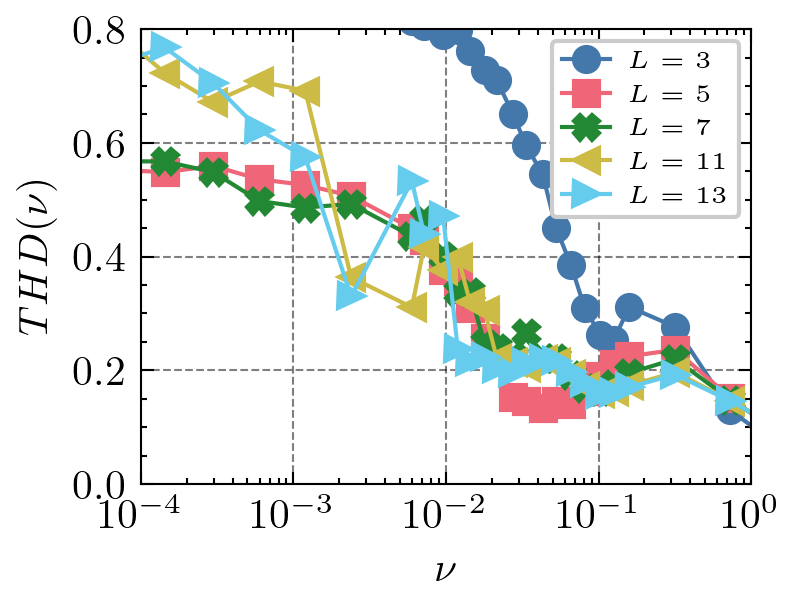

In [16]:
fig     = plt.figure(dpi=300)
ax      = fig.add_subplot()
w, h    = fig.get_size_inches()
scale   = 0.75
fig.set_size_inches(w * scale, h * scale)
for i, N in enumerate(N_PARTICLES):
    # _   = ax.errorbar(x=np.array(FREQ_LIST_MHZ)/F0_SET, y=np.mean(thd_vals[N],axis=1), yerr=np.std(thd_vals[N],axis=1), 
    #                   marker=marker[i], label=rf'$L = {N}$')
    _   = ax.plot(np.array(FREQ_LIST_MHZ)/F0_SET, thd_vals[N], marker=marker[i], label=rf'$L = {N}$')
_ = ax.set_xscale('log')
_ = ax.set_xlabel("$\\nu$")
_ = ax.set_ylabel("$THD(\\nu)$")
_ = ax.legend(fontsize='xx-small', loc='upper right', ncol=1)
# _ = ax.set_xlim(1e-4,1e0)
_ = ax.set_ylim(0,0.8)
_ = ax.set_xlim(1e-4,1e0)

# fig.savefig(f"plots/pdf/THD_scaling.pdf", transparent=False)
# fig.savefig(f"plots/svg/THD_scaling.svg", transparent=True)
# fig.savefig(f"plots/png/THD_scaling.png", transparent=False)

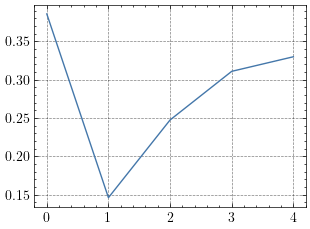

In [17]:
plt.plot([thd_vals[N][np.argmin(phase_I[N])] for N in N_PARTICLES])

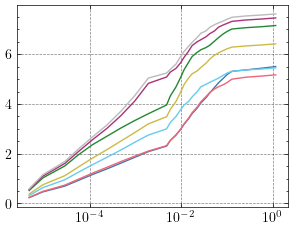

In [17]:
for N in N_PARTICLES:
    plt.plot(np.array(FREQ_LIST_MHZ)/F0_SET, np.cumsum(thd_vals[N]))
plt.xscale('log')

### Output Node Potential

In [346]:
h0s_V_out   = {N : np.array([extract_harmonic_features(p[N][f0][:,-(N//2)-1], n_vals=[1], mode='abs', pad_len=4096) for f0 in FREQ_LIST_MHZ]).flatten() for N in N_PARTICLES}
gain_V_out  = {N : h0s_V_out[N]/AMPLITUDE_LIST[N] for N in N_PARTICLES}

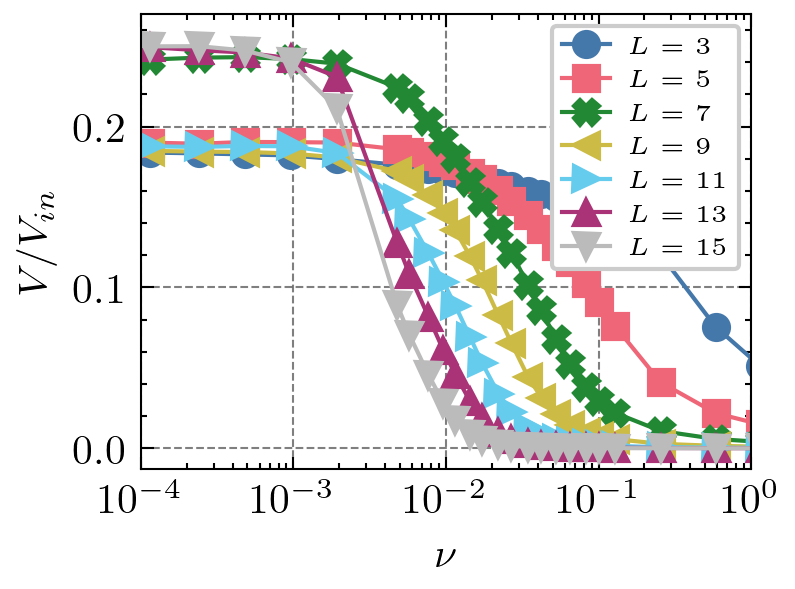

In [347]:
cmap    = plt.get_cmap('cividis')
marker  = ['o','s','X','<','>','^','v']
fig     = plt.figure(dpi=300)
ax      = fig.add_subplot()
w, h    = fig.get_size_inches()
scale   = 0.75
fig.set_size_inches(w * scale, h * scale)

# Current
for i, N in enumerate(N_PARTICLES):
    ax.plot(np.array(FREQ_LIST_MHZ)/F0_SET, gain_V_out[N], marker=marker[i], label=rf'$L = {N}$')
_ = ax.set_xscale('log')
_ = ax.set_xlabel("$\\nu$")
_ = ax.set_ylabel("$V/V_{in}$")
_ = ax.set_xlim(1e-4,1e0)
_ = ax.legend(fontsize='xx-small', loc='upper right', ncol=1)

# fig.savefig(f"plots/pdf/I_f0_gain_scaling.pdf", transparent=False)
# fig.savefig(f"plots/svg/I_f0_gain_scaling.svg", transparent=True)
# fig.savefig(f"plots/png/I_f0_gain_scaling.png", transparent=False)

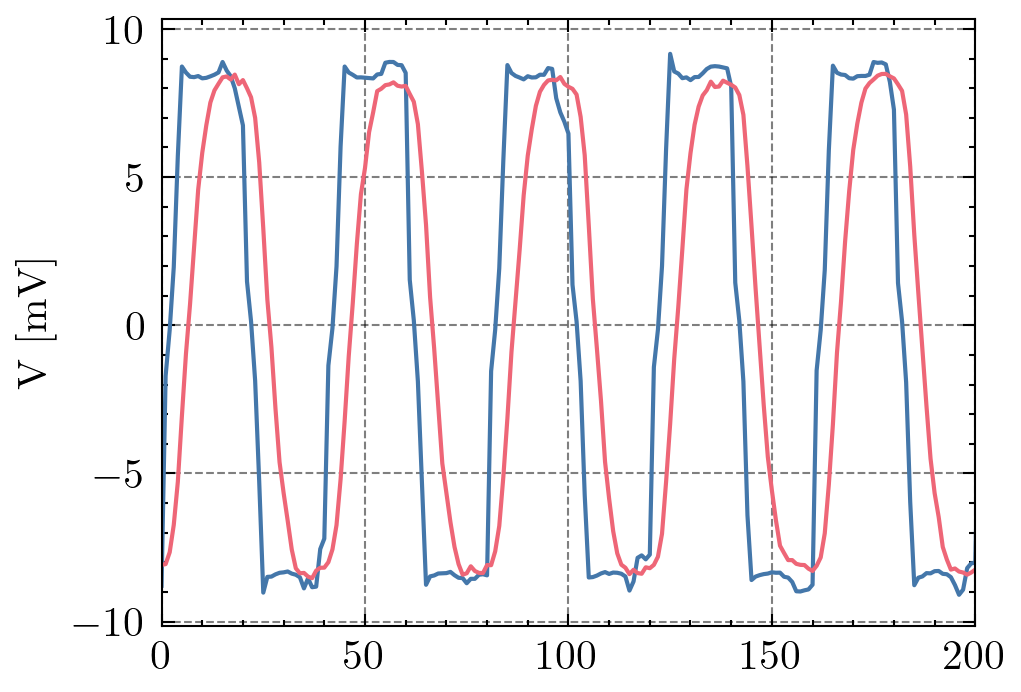

In [348]:
N       = 13
fig, ax = plt.subplots(dpi=300)
f0      = FREQ_LIST_MHZ[0]
_       = ax.plot(p[N][f0][:,-(N//2)-1]*1000)
# _       = ax.plot(time[f0][:(N_PERIODS-N_SKIP)*SAMPLE_P_PERIOD], p[N][f0][:,-(N//2)-1]*1000)
f0      = FREQ_LIST_MHZ[8]
_       = ax.plot(p[N][f0][:-1,-(N//2)-1]*1000)
# _       = ax.plot(time[f0][:(N_PERIODS-N_SKIP)*SAMPLE_P_PERIOD], p[N][f0][:-1,-(N//2)-1]*1000)
_       = ax.set_xlim(0,200)
_       = ax.set_ylabel("V [mV]")

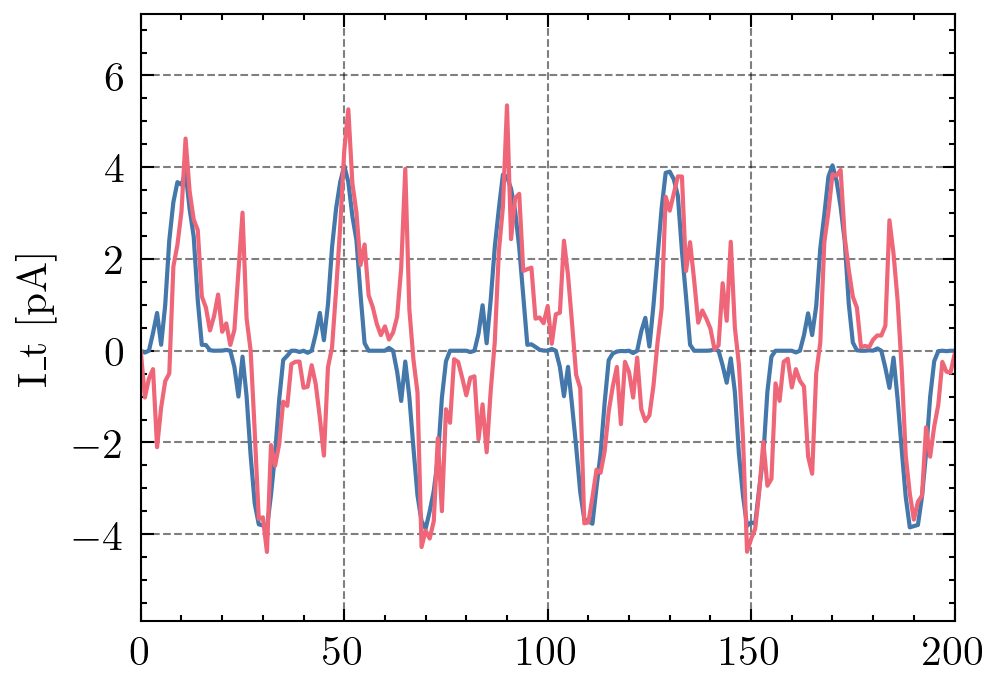

In [349]:
N       = 13
fig, ax = plt.subplots(dpi=300)
f0      = FREQ_LIST_MHZ[0]
_       = ax.plot(y_t[N][f0]*1e-6)
f0      = FREQ_LIST_MHZ[8]
_       = ax.plot(y_t[N][f0]*1e-6)
_       = ax.set_xlim(0,200)
_       = ax.set_ylabel("I_t [pA]")

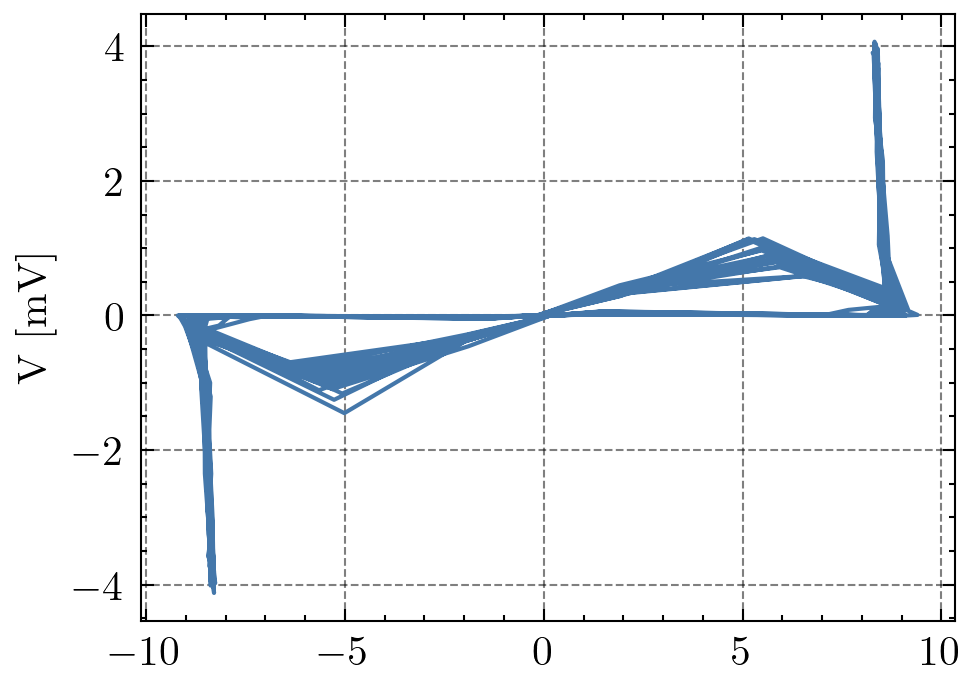

In [350]:
N       = 13
fig, ax = plt.subplots(dpi=300)
f0      = FREQ_LIST_MHZ[0]
_       = ax.plot(p[N][f0][:,-(N//2)-1]*1000, y_t[N][f0]*1e-6)
# _       = ax.plot(time[f0][:(N_PERIODS-N_SKIP)*SAMPLE_P_PERIOD], p[N][f0][:,-(N//2)-1]*1000)
# f0      = FREQ_LIST_MHZ[8]
# _       = ax.plot(p[N][f0][:,-(N//2)-1]*1000, y_t[N][f0]*1e-6)
# _       = ax.plot(time[f0][:(N_PERIODS-N_SKIP)*SAMPLE_P_PERIOD], p[N][f0][:-1,-(N//2)-1]*1000)
# _       = ax.set_xlim(0,0.00001)
_       = ax.set_ylabel("V [mV]")

---

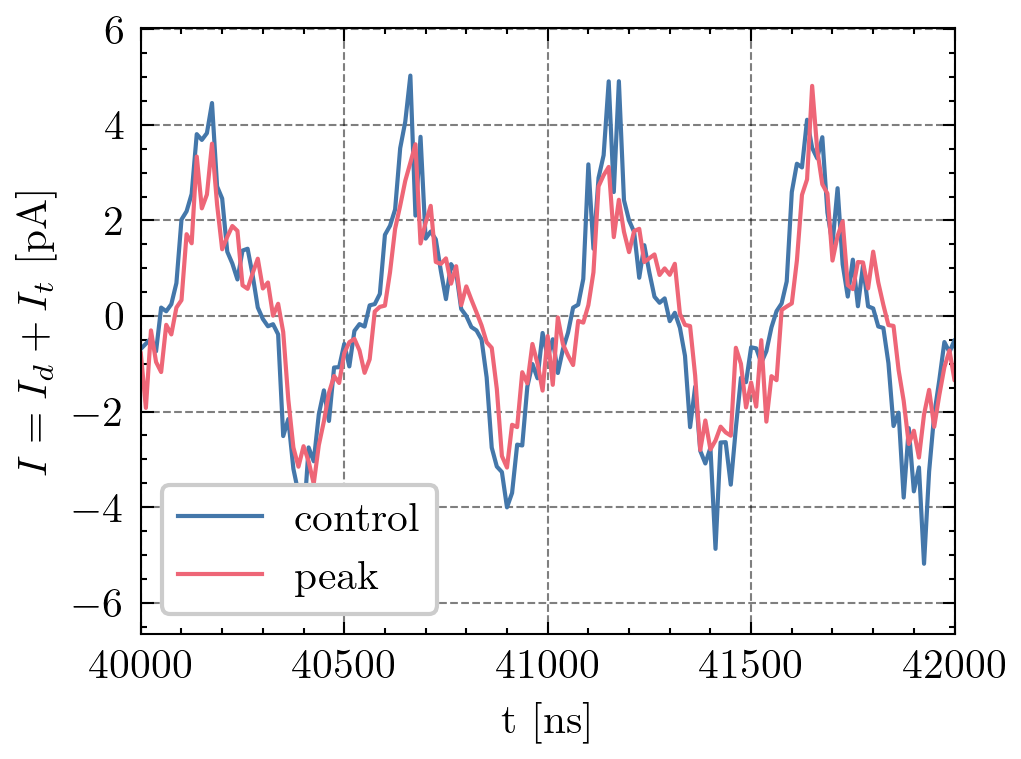

In [148]:
f0      = FREQ_LIST_MHZ[8]
p_net   = 13
c_net   = 11

fig,ax  = plt.subplots(dpi=300)
_       = ax.plot(time[f0][N_SKIP*SAMPLE_P_PERIOD:]*1e9, y[c_net][f0]*1e-6, label='control')
_       = ax.plot(time[f0][N_SKIP*SAMPLE_P_PERIOD:]*1e9, y[p_net][f0]*1e-6, label='peak')
_       = ax.set_xlim(40000,42000)
_       = ax.set_xlabel("t [ns]")
_       = ax.set_ylabel("$I = I_d + I_t$ [pA]")
_       = ax.legend()

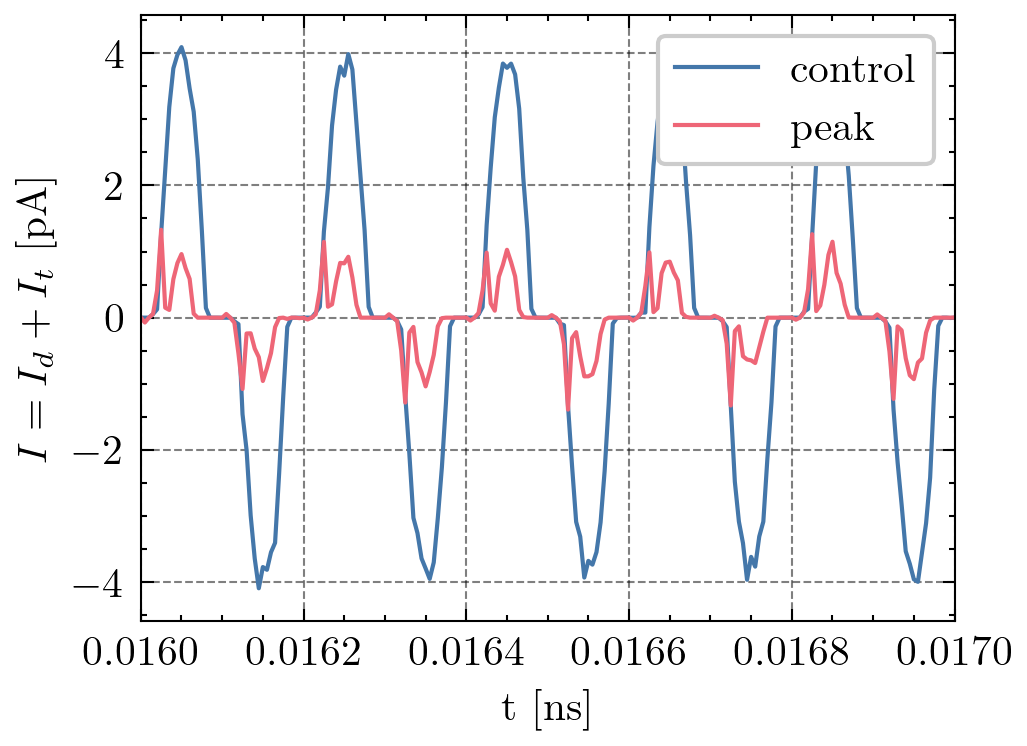

In [147]:
f0      = FREQ_LIST_MHZ[0]
p_net   = 13
c_net   = 11

fig,ax  = plt.subplots(dpi=300)
_       = ax.plot(time[f0][N_SKIP*SAMPLE_P_PERIOD:], y[c_net][f0]*1e-6, label='control')
_       = ax.plot(time[f0][N_SKIP*SAMPLE_P_PERIOD:], y[p_net][f0]*1e-6, label='peak')
_       = ax.set_xlim(0.016, 0.017)
_       = ax.set_xlabel("t [ns]")
_       = ax.set_ylabel("$I = I_d + I_t$ [pA]")
_       = ax.legend()

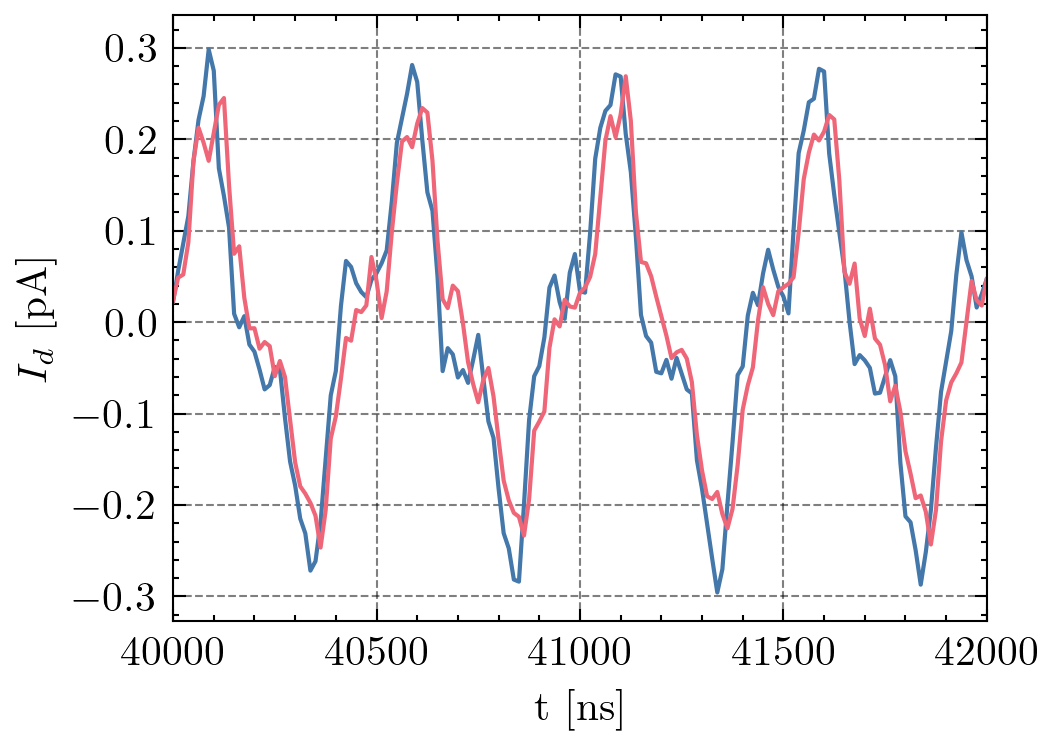

In [126]:
f0      = FREQ_LIST_MHZ[8]
p_net   = 13
c_net   = 11

fig,ax  = plt.subplots(dpi=300)
_       = ax.plot(time[f0][N_SKIP*SAMPLE_P_PERIOD:]*1e9, y_d[c_net][f0]*1e-6)
_       = ax.plot(time[f0][N_SKIP*SAMPLE_P_PERIOD:]*1e9, y_d[p_net][f0]*1e-6)
_       = ax.set_xlim(40000,42000)
_       = ax.set_xlabel("t [ns]")
_       = ax.set_ylabel("$I_d$ [pA]")

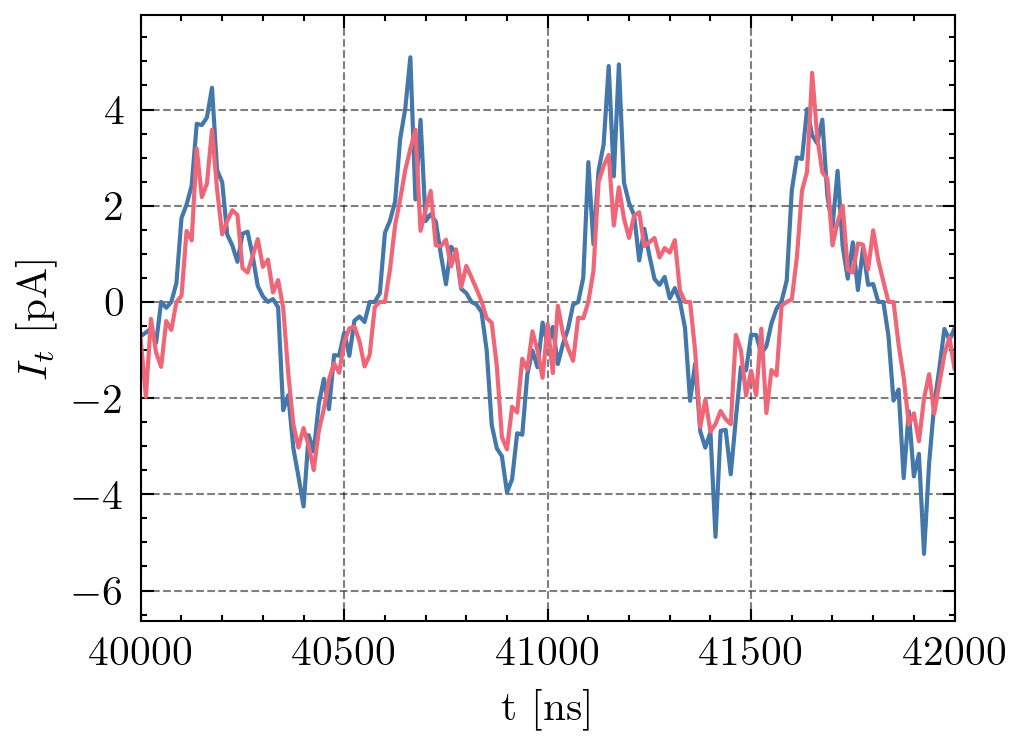

In [128]:
f0      = FREQ_LIST_MHZ[8]
p_net   = 13
c_net   = 11

fig,ax  = plt.subplots(dpi=300)
_       = ax.plot(time[f0][N_SKIP*SAMPLE_P_PERIOD:]*1e9, y_t[c_net][f0]*1e-6)
_       = ax.plot(time[f0][N_SKIP*SAMPLE_P_PERIOD:]*1e9, y_t[p_net][f0]*1e-6)
_       = ax.set_xlim(40000,42000)
_       = ax.set_xlabel("t [ns]")
_       = ax.set_ylabel("$I_t$ [pA]")

In [ ]:
# save_folder = "/mnt/c/Users/jonas/Desktop/phd/data/2_funding_period/dynamic/AC/amp_freq_size/"
# for N in N_PARTICLES:
#     for freq in FREQ_LIST_MHZ:
        # np.save(f"{save_folder}_x_{N}_{freq}.npy", x[N][freq])
        # np.save(f"{save_folder}_y_{N}_{freq}.npy", y[N][freq])
        # np.save(f"{save_folder}_p_{N}_{freq}.npy", p[N][freq])
        # np.save(f"{save_folder}_states_{N}_{freq}.npy", states[N][freq].iloc[N_SKIP*SAMPLE_P_PERIOD:,8:].values)
        # currents[N][freq].to_csv(f"{save_folder}_I_{N}_{freq}.csv")

In [ ]:
# x   = {}
# y   = {}
# p   = {}
# p_s = {}
# for N in N_PARTICLES:
#     x_tmp   = {}
#     y_tmp   = {}
#     p_tmp   = {}
#     p_s_tmp = {}
#     for freq in FREQ_LIST_MHZ:
#         x_tmp[freq] = np.load(f"{save_folder}_x_{N}_{freq}.npy")
#         y_tmp[freq] = np.load(f"{save_folder}_y_{N}_{freq}.npy")
#         p_tmp[freq] = np.load(f"{save_folder}_p_{N}_{freq}.npy")
#         p_s_tmp[freq] = np.load(f"{save_folder}_states_{N}_{freq}.npy")
#     x[N]    = x_tmp
#     y[N]    = y_tmp
#     p[N]    = p_tmp
#     p_s[N]  = p_s_tmp
#     currents[N][freq].to_csv(f"{save_folder}_I_{N}_{freq}.csv")

### Potential Gain

In [412]:
h0s_p   = {}
gain_p  = {}
for N in N_PARTICLES:
    h0s_p[N] = np.zeros(shape=(len(FREQ_LIST_MHZ),N*N))
    for i, freq in enumerate(FREQ_LIST_MHZ):
        for j in range(N*N):
            p_val   = p[N][freq][:,j].copy()
            h0      = extract_harmonic_features(p_val, n_vals=[1], mode='abs', pad_len=4096)
            h0s_p[N][i,j] = h0[0]
    # gain_p[N] = h0s_p[N]/AMPLITUDE_LIST[N]
    gain_p[N] = 20*np.log10(h0s_p[N]/h0s_p[N][0,:])
    # gain_p[N] = 20*np.log10(h0s_p[N]/AMPLITUDE_LIST[N])

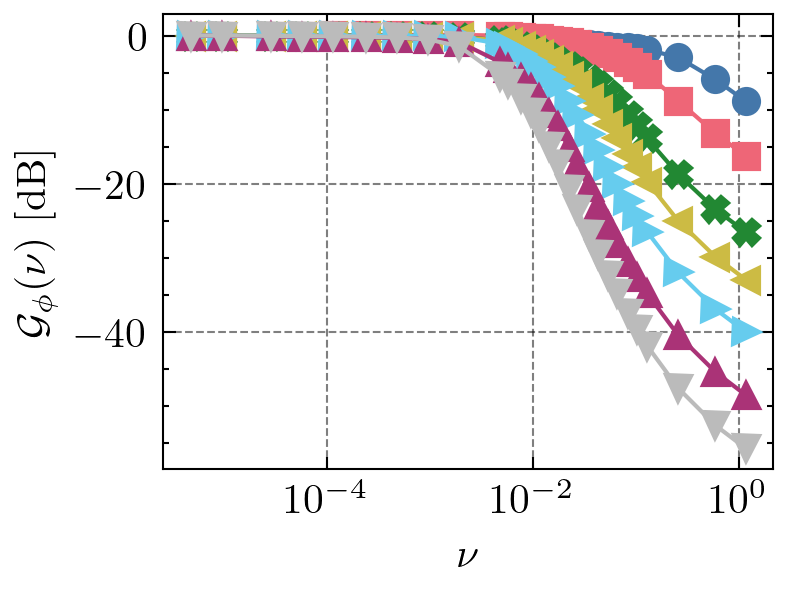

In [413]:
cmap    = plt.get_cmap('cividis')
marker  = ['o','s','X','<','>','^','v']
fig     = plt.figure(dpi=300)
ax      = fig.add_subplot()
w, h    = fig.get_size_inches()
scale   = 0.75
fig.set_size_inches(w * scale, h * scale)

# Potential
for i, N in enumerate(N_PARTICLES):
    # y_errs = np.array([gain_p[N].min(axis=1), gain_p[N].max(axis=1)])
    ax.plot(np.array(FREQ_LIST_MHZ)/F0_SET, np.mean(gain_p[N],axis=1), marker=marker[i], label=rf'$L = {N}$')
    # ax.fill_between(np.array(FREQ_LIST_MHZ)/F0_SET, np.quantile(gain_p[N],q=0.1,axis=1), np.quantile(gain_p[N],q=0.9,axis=1), alpha=0.5)
_ = ax.set_xscale('log')
_ = ax.set_xlabel("$\\nu$")
_ = ax.set_ylabel("$\mathcal{G}_\phi(\\nu)$ [dB]")
# _ = ax.set_xlim(1e-4,1e0)
# _ = ax.set_ylim(-7,4)
# _ = ax.legend(fontsize='x-small', loc='upper right', ncol=2)

# fig.savefig(f"plots/pdf/pot_f0_gain_scaling.pdf", transparent=False)
# fig.savefig(f"plots/svg/pot_f0_gain_scaling.svg", transparent=True)
# fig.savefig(f"plots/png/pot_f0_gain_scaling.png", transparent=False)

In [416]:
def extract_fc_from_gain(freqs, gain_db, threshold=-3.0):
    """Interpolates the frequency where Gain crosses threshold."""
    # Assuming monotonic rolloff in the cutoff region
    # Find last point above and first point below
    
    # Safety: Check if we ever cross
    if np.min(gain_db) > threshold:
        return np.nan
    
    # Find index where it drops
    idx = np.where(gain_db < threshold)[0][0]
    
    if idx == 0: return np.nan # Started below
    
    f1, f2 = freqs[idx-1], freqs[idx]
    g1, g2 = gain_db[idx-1], gain_db[idx]
    
    # Linear interpolation
    slope = (f2 - f1) / (g2 - g1)
    f_c = f1 + slope * (threshold - g1)
    
    return f_c

fc_pot = np.array([extract_fc_from_gain(FREQ_LIST_MHZ, np.mean(gain_p[N],axis=1)) for N in N_PARTICLES])/F0_SET

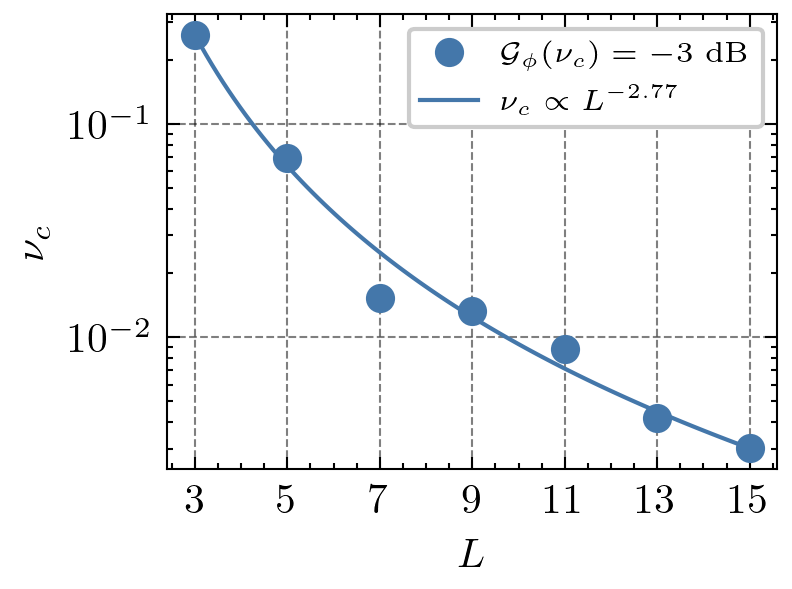

In [417]:
def power_law(x,a,b):
    return a*x**b
def exp_law(x,a,b):
    return a*np.exp(b*x)

fig     = plt.figure(dpi=300)
ax      = fig.add_subplot()
w, h    = fig.get_size_inches()
scale   = 0.75
fig.set_size_inches(w * scale, h * scale)

f_vals  = np.linspace(N_PARTICLES[0], N_PARTICLES[-1], 100)
pp      = ax.plot(np.array(N_PARTICLES), fc_pot, marker='o', label='$\mathcal{G}_{\phi}(\\nu_c) = -3~\mathrm{dB}$', ls='')
pa,_    = curve_fit(power_law, np.array(N_PARTICLES)[0:], fc_pot[0:])
_       = ax.plot(f_vals, power_law(f_vals,*pa), label=f'$\\nu_c \propto L^{{{pa[1]:.2f}}}$', color=pp[0].get_color())
_       = ax.set_ylabel('$\\nu_c$')
_       = ax.set_xlabel('$L$')
_       = ax.legend(fontsize='x-small')
_       = ax.set_yscale('log')
# _       = ax.set_ylim(1e-2,4e-1)
_       = ax.set_xticks(N_PARTICLES)

# fig.savefig(f"plots/pdf/fc_scaling.pdf", transparent=False)
# fig.savefig(f"plots/svg/fc_scaling.svg", transparent=True)
# fig.savefig(f"plots/png/fc_scaling.png", transparent=False)

### Current Gain

In [352]:
B = 200
if B != 0:
    h0s_I   = {N : np.array([[extract_harmonic_features(y[N][f0]+np.random.normal(0, y_e[N][f0]/1.96), n_vals=[1], mode='abs', pad_len=4096) for _ in range(B)] for f0 in FREQ_LIST_MHZ])[:,:,0] for N in N_PARTICLES}
    gain_I  = {N : 20*np.log10(h0s_I[N]/h0s_I[N][0]) for N in N_PARTICLES}
    # gain_I  = {N : (h0s_I[N]*1e-6)/AMPLITUDE_LIST[N] for N in N_PARTICLES}
else:
    h0s_I   = {N : np.array([extract_harmonic_features(y[N][f0], n_vals=[1], mode='abs', pad_len=4096) for f0 in FREQ_LIST_MHZ]).flatten() for N in N_PARTICLES}
    gain_I  = {N : 20*np.log10(h0s_I[N]/h0s_I[N][0]) for N in N_PARTICLES}

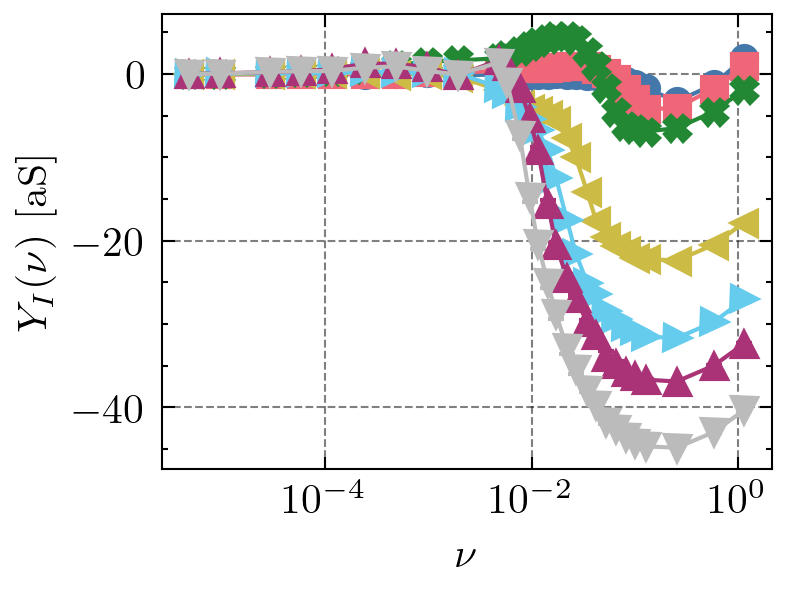

In [354]:
cmap    = plt.get_cmap('cividis')
marker  = ['o','s','X','<','>','^','v']
fig     = plt.figure(dpi=300)
ax      = fig.add_subplot()
w, h    = fig.get_size_inches()
scale   = 0.75
fig.set_size_inches(w * scale, h * scale)

# Current
for i, N in enumerate(N_PARTICLES):
    ax.errorbar(np.array(FREQ_LIST_MHZ)/F0_SET, np.mean(gain_I[N],axis=1).flatten(), 1.96*np.std(gain_I[N],axis=1).flatten(), marker=marker[i], label=rf'$L = {N}$', capsize=2)
    # ax.plot(np.array(FREQ_LIST_MHZ)/F0_SET, gain_I[N], marker=marker[i], label=rf'$L = {N}$')
_ = ax.set_xscale('log')
_ = ax.set_xlabel("$\\nu$")
_ = ax.set_ylabel("$Y_{I}(\\nu)$ [aS]")
# _ = ax.set_xlim(1e-4,1e0)
# _ = ax.set_ylim(1e-1,2e3)
# _ = ax.set_yscale('log')
# _ = ax.set_ylim(-35,15)
# _ = ax.legend(fontsize='x-small', loc='lower left', ncol=1)

# fig.savefig(f"plots/pdf/I_f0_gain_scaling.pdf", transparent=False)
# fig.savefig(f"plots/svg/I_f0_gain_scaling.svg", transparent=True)
# fig.savefig(f"plots/png/I_f0_gain_scaling.png", transparent=False)

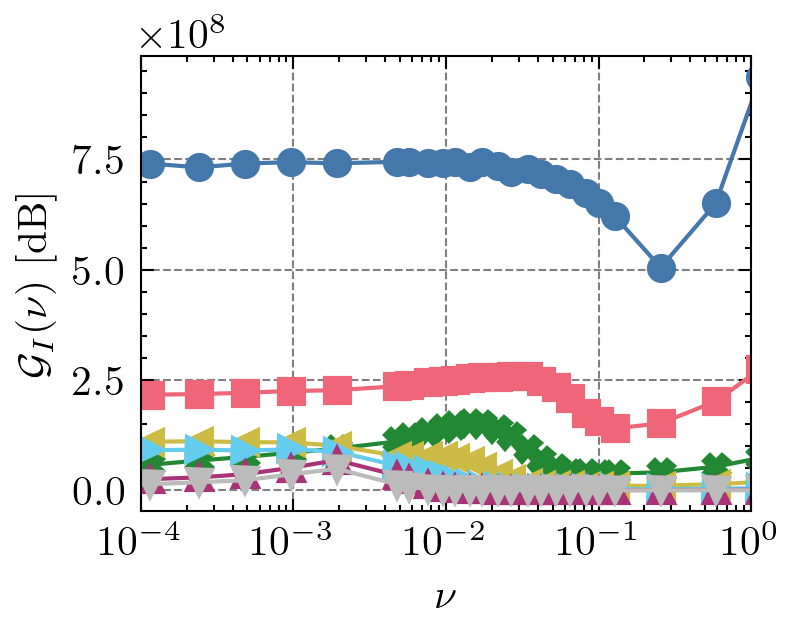

In [157]:
cmap    = plt.get_cmap('cividis')
marker  = ['o','s','X','<','>','^','v']
fig     = plt.figure(dpi=300)
ax      = fig.add_subplot()
w, h    = fig.get_size_inches()
scale   = 0.75
fig.set_size_inches(w * scale, h * scale)

# Current
for i, N in enumerate(N_PARTICLES):
    ax.errorbar(np.array(FREQ_LIST_MHZ)/F0_SET, np.mean(gain_I[N],axis=1).flatten(), 1.96*np.std(gain_I[N],axis=1).flatten(), marker=marker[i], label=rf'$L = {N}$', capsize=2)
    # ax.plot(np.array(FREQ_LIST_MHZ)/F0_SET, gain_I[N], marker=marker[i], label=rf'$L = {N}$')
_ = ax.set_xscale('log')
_ = ax.set_xlabel("$\\nu$")
_ = ax.set_ylabel("$\mathcal{G}_{I}(\\nu)$ [dB]")
_ = ax.set_xlim(1e-4,1e0)
# _ = ax.set_ylim(-35,15)
_ = ax.legend(fontsize='x-small', loc='lower left', ncol=1)

# fig.savefig(f"plots/pdf/I_f0_gain_scaling.pdf", transparent=False)
# fig.savefig(f"plots/svg/I_f0_gain_scaling.svg", transparent=True)
# fig.savefig(f"plots/png/I_f0_gain_scaling.png", transparent=False)

### Tunneling Gain vs System Size

In [169]:
B = 200
if B != 0:
    h0s_I_t   = {N : np.array([[extract_harmonic_features(y_t[N][f0]+np.random.normal(0, y_e[N][f0]/1.96), n_vals=[1], mode='abs', pad_len=4096) for _ in range(B)] for f0 in FREQ_LIST_MHZ])[:,:,0] for N in N_PARTICLES}
    # gain_I_t  = {N : 20*np.log10(h0s_I_t[N]/h0s_I_t[N][0]) for N in N_PARTICLES}
    gain_I_t  = {N : (h0s_I_t[N]*1e-6)/AMPLITUDE_LIST[N] for N in N_PARTICLES}
else:
    h0s_I_t   = {N : np.array([extract_harmonic_features(y_t[N][f0], n_vals=[1], mode='abs', pad_len=4096) for f0 in FREQ_LIST_MHZ]).flatten() for N in N_PARTICLES}
    gain_I_t  = {N : 20*np.log10(h0s_I_t[N]/h0s_I_t[N][0]) for N in N_PARTICLES}

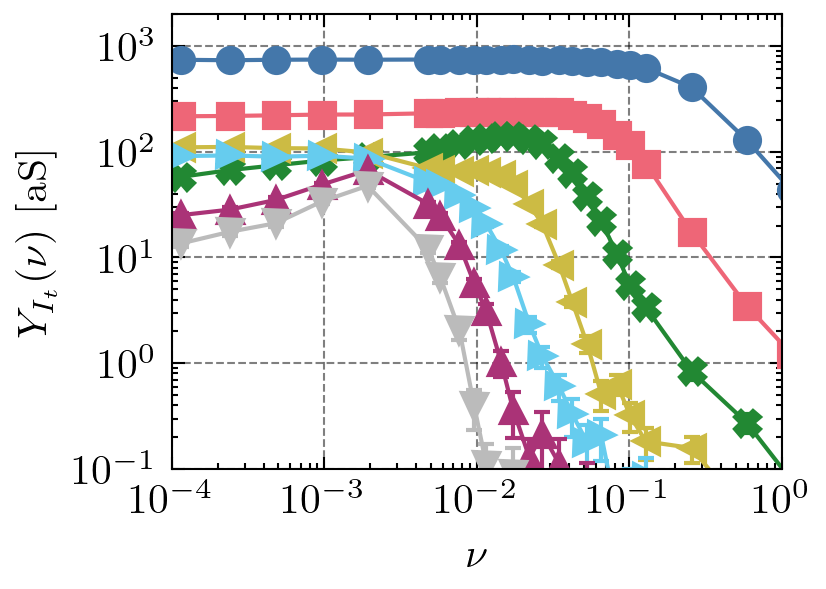

In [194]:
cmap    = plt.get_cmap('cividis')
marker  = ['o','s','X','<','>','^','v']
fig     = plt.figure(dpi=300)
ax      = fig.add_subplot()
w, h    = fig.get_size_inches()
scale   = 0.75
fig.set_size_inches(w * scale, h * scale)

# Current
for i, N in enumerate(N_PARTICLES):
    ax.errorbar(np.array(FREQ_LIST_MHZ)/F0_SET, np.mean(gain_I_t[N],axis=1).flatten(), 1.96*np.std(gain_I_t[N],axis=1).flatten(), marker=marker[i], label=rf'$L = {N}$', capsize=2)
    # ax.plot(np.array(FREQ_LIST_MHZ)/F0_SET, gain_I[N], marker=marker[i], label=rf'$L = {N}$')
_ = ax.set_xscale('log')
_ = ax.set_xlabel("$\\nu$")
_ = ax.set_ylabel("$Y_{I_t}(\\nu)$ [aS]")
_ = ax.set_xlim(1e-4,1e0)
_ = ax.set_yscale('log')
_ = ax.set_ylim(1e-1,2e3)
# _ = ax.legend(fontsize='x-small', loc='lower left', ncol=1)

# fig.savefig(f"plots/pdf/I_f0_gain_scaling.pdf", transparent=False)
# fig.savefig(f"plots/svg/I_f0_gain_scaling.svg", transparent=True)
# fig.savefig(f"plots/png/I_f0_gain_scaling.png", transparent=False)

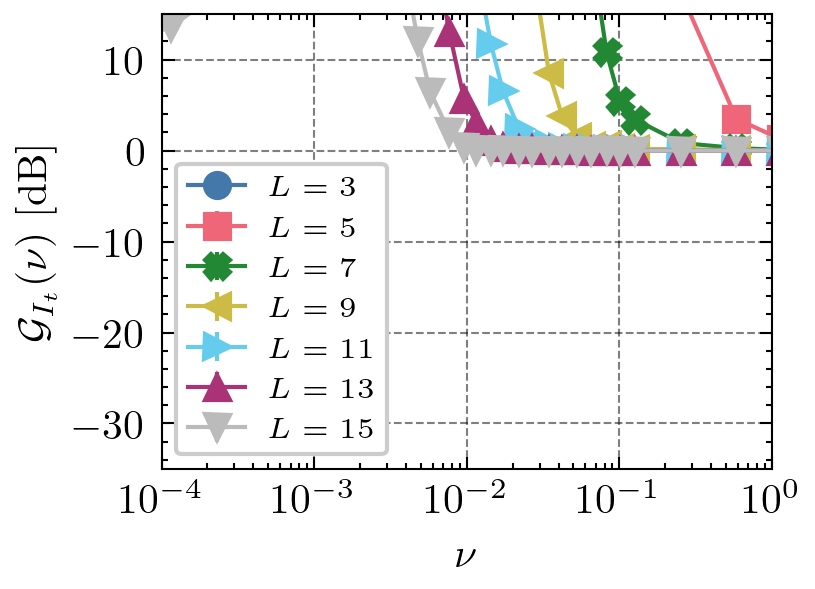

In [191]:
cmap    = plt.get_cmap('cividis')
marker  = ['o','s','X','<','>','^','v']

fig     = plt.figure(dpi=300)
ax      = fig.add_subplot()
w, h    = fig.get_size_inches()
scale   = 0.75
fig.set_size_inches(w * scale, h * scale)

# Current
for i, N in enumerate(N_PARTICLES):
    ax.errorbar(np.array(FREQ_LIST_MHZ)/F0_SET, np.mean(gain_I_t[N],axis=1).flatten(), np.std(gain_I_t[N],axis=1).flatten(), marker=marker[i], label=rf'$L = {N}$')
_ = ax.set_xscale('log')
_ = ax.set_xlabel("$\\nu$")
_ = ax.set_ylabel("$\mathcal{G}_{I_t}(\\nu)$ [dB]")
_ = ax.set_xlim(1e-4,1e0)
_ = ax.set_ylim(-35,15)
_ = ax.legend(fontsize='x-small', loc='lower left', ncol=1)

fig.savefig(f"plots/pdf/I_t_f0_gain_scaling.pdf", transparent=False)
fig.savefig(f"plots/svg/I_t_f0_gain_scaling.svg", transparent=True)
fig.savefig(f"plots/png/I_t_f0_gain_scaling.png", transparent=False)

### Displacement Gain vs System Size

In [183]:
h0s_I_d   = {N : np.array([extract_harmonic_features(y_d[N][f0], n_vals=[1], mode='abs', pad_len=4096) for f0 in FREQ_LIST_MHZ]).flatten() for N in N_PARTICLES}
# gain_I_d  = {N : 20*np.log10(h0s_I_d[N]/h0s_I_d[N][0]) for N in N_PARTICLES}
gain_I_d  = {N : (h0s_I_d[N]*1e-6)/AMPLITUDE_LIST[N] for N in N_PARTICLES}

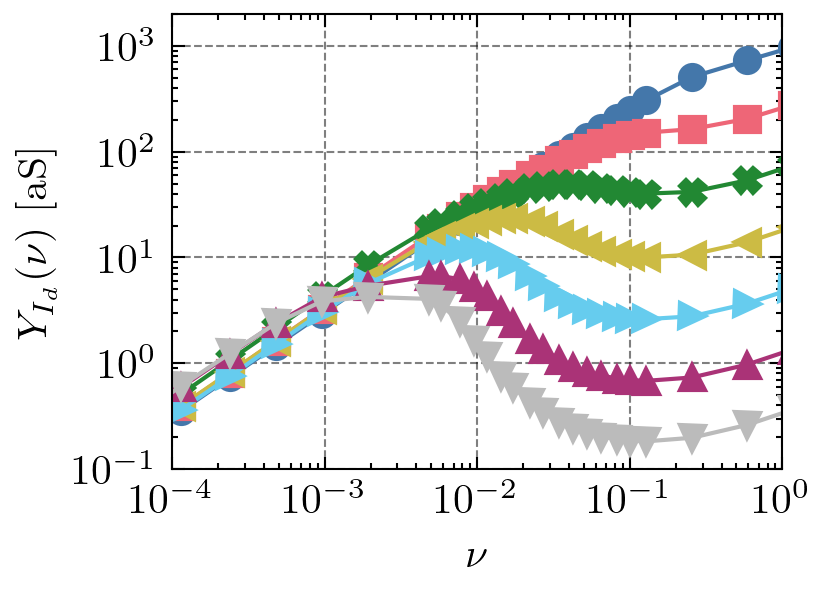

In [187]:
cmap    = plt.get_cmap('cividis')
marker  = ['o','s','X','<','>','^','v']
fig     = plt.figure(dpi=300)
ax      = fig.add_subplot()
w, h    = fig.get_size_inches()
scale   = 0.75
fig.set_size_inches(w * scale, h * scale)

# Current
for i, N in enumerate(N_PARTICLES):
    ax.plot(np.array(FREQ_LIST_MHZ)/F0_SET, gain_I_d[N], marker=marker[i], label=rf'$L = {N}$')
_ = ax.set_xscale('log')
_ = ax.set_xlabel("$\\nu$")
_ = ax.set_ylabel("$Y_{I_d}(\\nu)$ [aS]")
_ = ax.set_xlim(1e-4,1e0)
_ = ax.set_yscale('log')
_ = ax.set_ylim(1e-1,2e3)
# _ = ax.legend(fontsize='x-small', loc='lower left', ncol=1)

# fig.savefig(f"plots/pdf/I_f0_gain_scaling.pdf", transparent=False)
# fig.savefig(f"plots/svg/I_f0_gain_scaling.svg", transparent=True)
# fig.savefig(f"plots/png/I_f0_gain_scaling.png", transparent=False)

In [235]:
h0s_I_d   = {N : np.array([extract_harmonic_features(p[N][f0][:,-(N//2)-1], n_vals=[1], mode='abs', pad_len=4096) for f0 in FREQ_LIST_MHZ]).flatten() for N in N_PARTICLES}
# gain_I_d  = {N : 20*np.log10(h0s_I_d[N]/h0s_I_d[N][0]) for N in N_PARTICLES}
gain_I_d  = {N : (h0s_I_d[N]*1e-6)/AMPLITUDE_LIST[N] for N in N_PARTICLES}

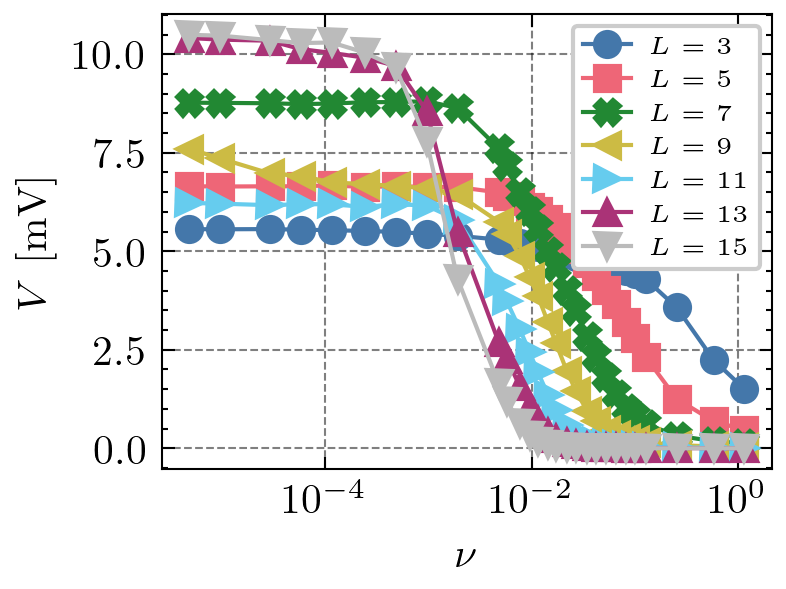

In [239]:
cmap    = plt.get_cmap('cividis')
marker  = ['o','s','X','<','>','^','v']
fig     = plt.figure(dpi=300)
ax      = fig.add_subplot()
w, h    = fig.get_size_inches()
scale   = 0.75
fig.set_size_inches(w * scale, h * scale)

# Current
for i, N in enumerate(N_PARTICLES):
    ax.plot(np.array(FREQ_LIST_MHZ)/F0_SET, h0s_I_d[N]*1000, marker=marker[i], label=rf'$L = {N}$')
_ = ax.set_xscale('log')
_ = ax.set_xlabel("$\\nu$")
_ = ax.set_ylabel("$V$ [mV]")
# _ = ax.set_xlim(1e-4,1e0)
# _ = ax.set_yscale('log')
# _ = ax.set_ylim(1e-1,2e3)
_ = ax.legend(fontsize='xx-small', loc='upper right', ncol=1)

# fig.savefig(f"plots/pdf/I_f0_gain_scaling.pdf", transparent=False)
# fig.savefig(f"plots/svg/I_f0_gain_scaling.svg", transparent=True)
# fig.savefig(f"plots/png/I_f0_gain_scaling.png", transparent=False)

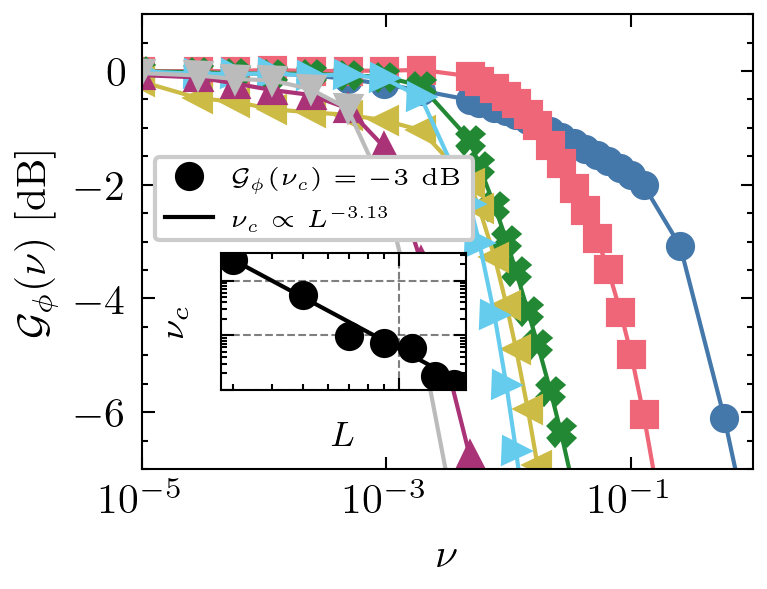

In [31]:
fig     = plt.figure(dpi=300)
ax      = fig.add_subplot()
w, h    = fig.get_size_inches()
scale   = 0.75
fig.set_size_inches(w * scale, h * scale)

# Potential
for i, N in enumerate(N_PARTICLES):
    ax.plot(np.array(FREQ_LIST_MHZ)/F0_SET, np.mean(gain_p[N],axis=1), marker=marker[i], label=rf'$L = {N}$')
_ = ax.set_xscale('log')
_ = ax.set_xlabel("$\\nu$")
_ = ax.set_ylabel("$\mathcal{G}_\phi(\\nu)$ [dB]")
_ = ax.set_xlim(1e-5,1e0)
_ = ax.set_ylim(-7,1)
_ = ax.grid(False)
# _ = ax.legend(fontsize='x-small', loc='upper right', ncol=2)

ax_in = inset_axes(ax, width="40%", height="30%", loc="lower left", borderpad=1.9)
pp  = ax_in.plot(np.array(N_PARTICLES), fc_pot, marker='o', label='$\mathcal{G}_{\phi}(\\nu_c) = -3~\mathrm{dB}$', ls='', color='black')
_   = ax_in.plot(f_vals, power_law(f_vals, *pa), label=rf'$\nu_c \propto L^{{{pa[1]:.2f}}}$', color=pp[0].get_color())
_   = ax_in.set_ylabel('$\\nu_c$', fontsize='small')
_   = ax_in.set_xlabel('$L$', fontsize='small')
_   = ax_in.legend(fontsize='xx-small', loc='center', bbox_to_anchor=(0.38,1.4))
_   = ax_in.set_xscale('log')
_   = ax_in.set_yscale('log')
# _   = ax_in.set_ylim(1e-2,4e-1)
# _   = ax_in.set_xticks(N_PARTICLES)
_   = ax_in.set_xticklabels("",minor=False)
_   = ax_in.set_xticklabels("",minor=True)
_   = ax_in.set_yticklabels("")

# fig.savefig(f"plots/pdf/pot_f0_gain_scaling_and_fc.pdf", transparent=False)
# fig.savefig(f"plots/svg/pot_f0_gain_scaling_and_fc.svg", transparent=True)
# fig.savefig(f"plots/png/pot_f0_gain_scaling_and_fc.png", transparent=False)

### Phase Lag

In [ ]:
def get_phase_lag(response_signal: np.ndarray, input_signal: np.ndarray) -> float:
    """
    Calculates the Phase Lag between a system response and the driving input 
    at the fundamental driving frequencyme-domain snippet (maybe 3 or 4 AC cycles) of the raw Observable Tunneling Current (y 
t
​
 ) side-by-side f
        Range is normalized to [-180, 180]. 
        Negative values indicate the response 'lags' behind the input (Capacitive).
        Positive values indicate the response 'leads' the input (Inductive).
    """
    
    # 1. Apply Windowing (Optional but recommended to reduce spectral leakage)
    # If your signal is an exact integer number of periods, you can skip this.
    # Otherwise, a Hanning window helps.
    # window = np.hanning(len(response_signal))
    # resp_w = response_signal * window
    # input_w = input_signal * window

    resp_w  = response_signal
    input_w  = input_signal
    
    # 2. Compute FFT
    # We use rfft because the signals are real-valued
    fft_resp = np.fft.rfft(resp_w)
    fft_in = np.fft.rfft(input_w)
    
    # 3. Find the Fundamental Frequency Index
    # We assume the input is a dominant sine wave, so we just find the max peak.
    # We skip index 0 (DC component).
    idx_fund = np.argmax(np.abs(fft_in[1:])) + 1
    
    # 4. Extract Angles (Phases) at that index
    angle_resp = np.angle(fft_resp[idx_fund])
    angle_in = np.angle(fft_in[idx_fund])
    
    # 5. Calculate Difference
    phase_diff = angle_resp - angle_in
        
    # 7. Normalize to [-180, 180] range
    # This handles wrap-around (e.g., if result is -270, it becomes +90)
    phase_diff = (phase_diff + np.pi) % (2 * np.pi) - np.pi
    
    return phase_diff / np.pi

In [91]:
input_peak          = x[13][FREQ_LIST_MHZ[8]].copy()
input_control       = x[11][FREQ_LIST_MHZ[8]].copy()
pot_land_peak       = p[13][FREQ_LIST_MHZ[8]].copy()
pot_land_control    = p[11][FREQ_LIST_MHZ[8]].copy()
phase_peak          = np.array([get_phase_lag(pot_land_peak[:,i], input_peak) for i in range(13*13)]).reshape(13,13)
phase_control       = np.array([get_phase_lag(pot_land_control[:,i], input_peak) for i in range(11*11)]).reshape(11,11)

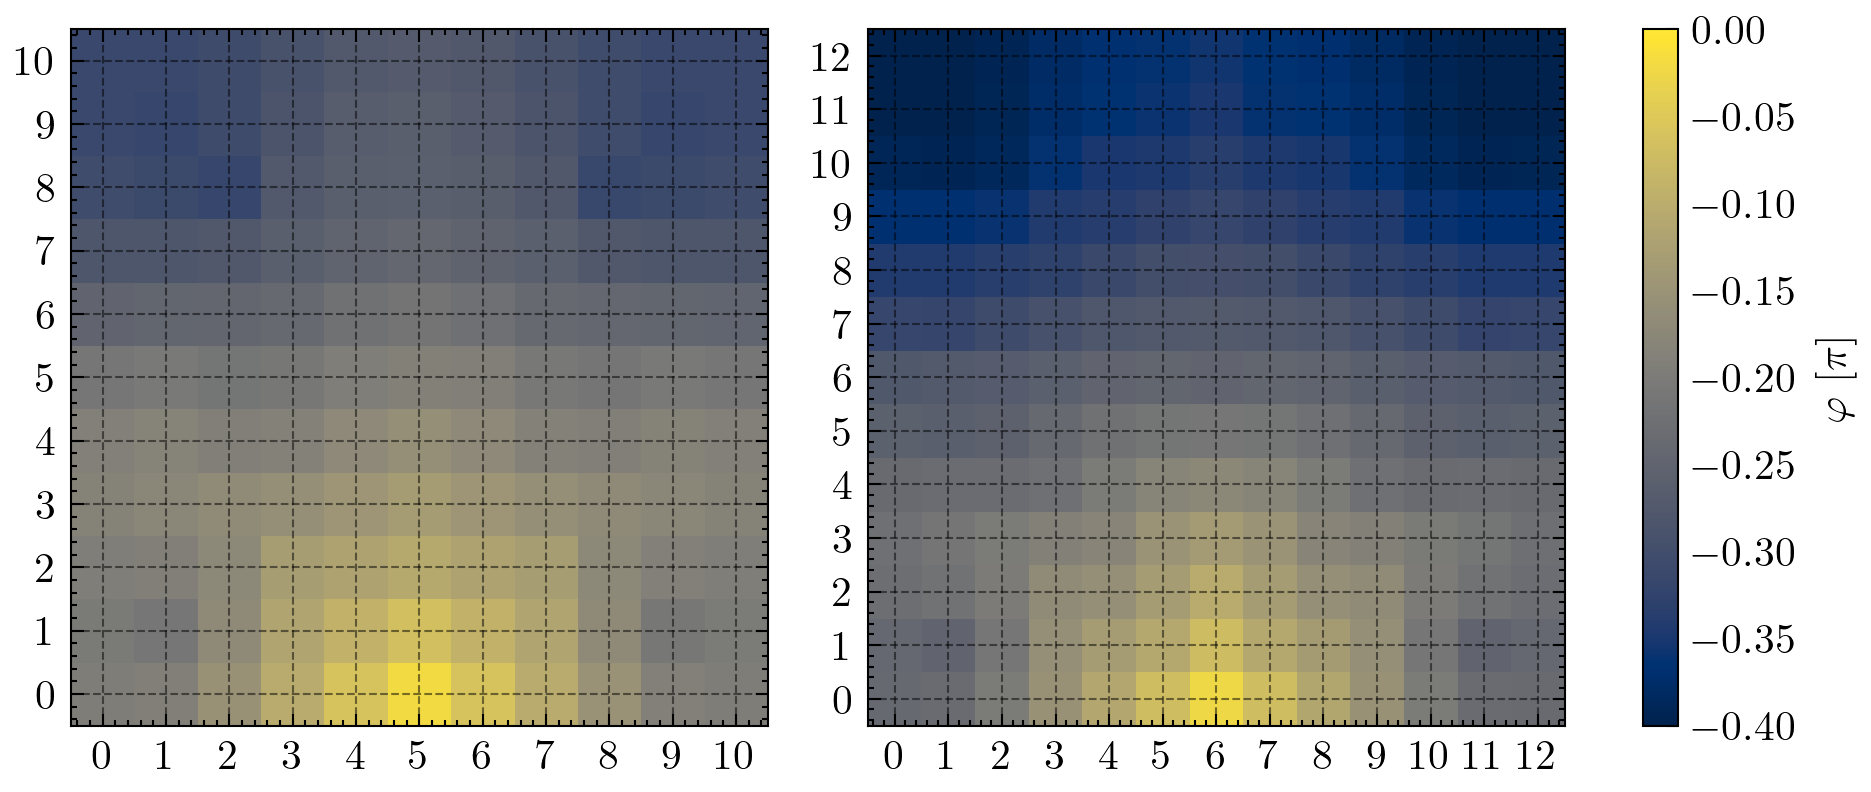

In [92]:
fig = plt.figure(dpi=300, layout='constrained') 
fig.set_figwidth(fig.get_figwidth()*1.8)
axs = []
ax  = plt.subplot(1,2,1)
axs.append(ax)
im  = ax.imshow(phase_control, vmin=-0.4, vmax=0, cmap='cividis', origin='lower')
_   = ax.set_xticks(np.arange(11))
_   = ax.set_yticks(np.arange(11))
ax  = plt.subplot(1,2,2)
axs.append(ax)
im  = ax.imshow(phase_peak, vmin=-0.4, vmax=0, cmap='cividis', origin='lower')
cb  = plt.colorbar(im, ax=axs, label='$\\varphi~[\mathrm{\\pi}]$')
_   = ax.set_xticks(np.arange(13))
_   = ax.set_yticks(np.arange(13))

In [81]:
phase_s     = {N : [get_phase_lag(p_m[N][freq],x[N][freq]) for freq in FREQ_LIST_MHZ] for N in N_PARTICLES}
phase_I     = {N : [get_phase_lag(y[N][freq],x[N][freq]) for freq in FREQ_LIST_MHZ] for N in N_PARTICLES}
phase_I_t   = {N : [get_phase_lag(y_t[N][freq],x[N][freq]) for freq in FREQ_LIST_MHZ] for N in N_PARTICLES}
phase_I_d   = {N : [get_phase_lag(y_d[N][freq],x[N][freq]) for freq in FREQ_LIST_MHZ] for N in N_PARTICLES}

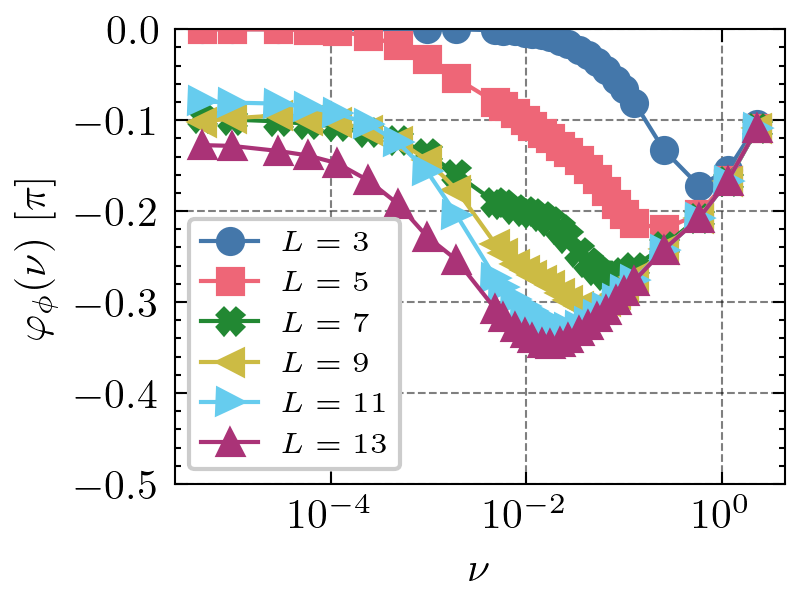

In [85]:
fig     = plt.figure(dpi=300)
ax      = fig.add_subplot()
w, h    = fig.get_size_inches()
scale   = 0.75
fig.set_size_inches(w * scale, h * scale)
for i, N in enumerate(N_PARTICLES):
    _   = ax.plot(np.array(FREQ_LIST_MHZ)/F0_SET, phase_s[N], marker=marker[i], label=rf'$L = {N}$')

_ = ax.set_xscale('log')
_ = ax.set_xlabel("$\\nu$")
_ = ax.set_ylabel("$\\varphi_{\phi}(\\nu)~[\mathrm{\pi}]$")
_ = ax.legend(fontsize='x-small', loc='lower left', ncol=1)
_ = ax.set_ylim(-0.5,0)
# _ = ax.set_xlim(1e-4,1e0)

fig.savefig(f"plots/pdf/pot_f0_phase_scaling.pdf", transparent=False)
fig.savefig(f"plots/svg/pot_f0_phase_scaling.svg", transparent=True)
fig.savefig(f"plots/png/pot_f0_phase_scaling.png", transparent=False)

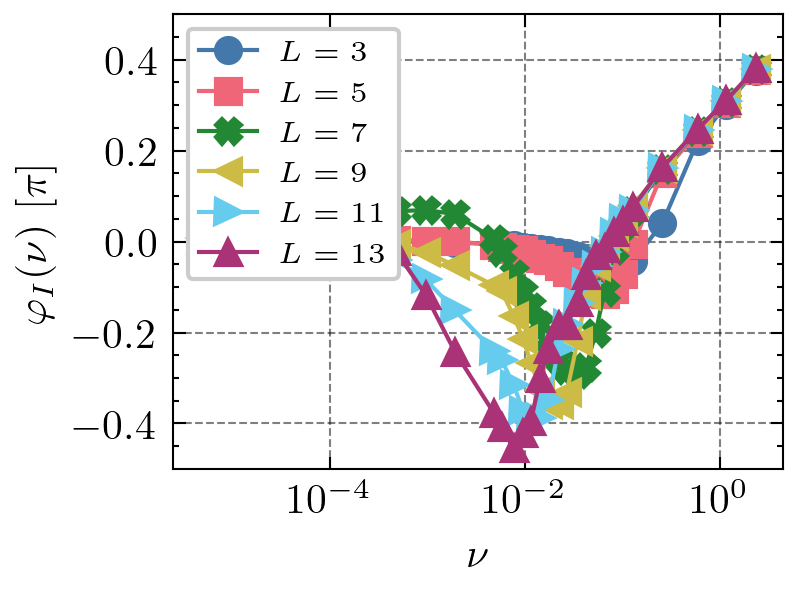

In [88]:
fig     = plt.figure(dpi=300)
ax      = fig.add_subplot()
w, h    = fig.get_size_inches()
scale   = 0.75
fig.set_size_inches(w * scale, h * scale)
for i, N in enumerate(N_PARTICLES):
    _   = ax.plot(np.array(FREQ_LIST_MHZ)/F0_SET, phase_I[N], marker=marker[i], label=rf'$L = {N}$')

_ = ax.set_xscale('log')
_ = ax.set_xlabel("$\\nu$")
_ = ax.set_ylabel("$\\varphi_{I}(\\nu)~[\mathrm{\pi}]$")
_ = ax.legend(fontsize='x-small', loc='upper left', ncol=1)
_ = ax.set_ylim(-0.5,0.5)
# _ = ax.set_xlim(1e-4,1e0)
# _ = plt.axvline(np.array(FREQ_LIST_MHZ)[12]/F0_SET)
# print(np.array(FREQ_LIST_MHZ)[12])

fig.savefig(f"plots/pdf/I_f0_phase_scaling.pdf", transparent=False)
fig.savefig(f"plots/svg/I_f0_phase_scaling.svg", transparent=True)
fig.savefig(f"plots/png/I_f0_phase_scaling.png", transparent=False)

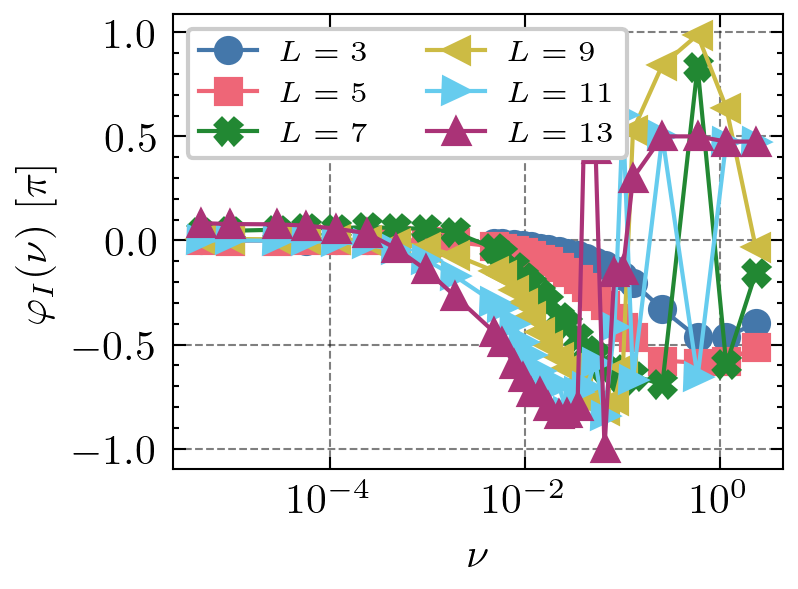

In [96]:
fig     = plt.figure(dpi=300)
ax      = fig.add_subplot()
w, h    = fig.get_size_inches()
scale   = 0.75
fig.set_size_inches(w * scale, h * scale)
for i, N in enumerate(N_PARTICLES):
    _   = ax.plot(np.array(FREQ_LIST_MHZ)/F0_SET, phase_I_t[N], marker=marker[i], label=rf'$L = {N}$')

_ = ax.set_xscale('log')
_ = ax.set_xlabel("$\\nu$")
_ = ax.set_ylabel("$\\varphi_{I}(\\nu)~[\mathrm{\pi}]$")
_ = ax.legend(fontsize='x-small', loc='upper left', ncol=2)
# _ = ax.set_ylim(-0.5,0.5)
# _ = ax.set_xlim(1e-4,1e0)
# _ = plt.axvline(np.array(FREQ_LIST_MHZ)[12]/F0_SET)
# print(np.array(FREQ_LIST_MHZ)[12])

fig.savefig(f"plots/pdf/I_t_f0_phase_scaling.pdf", transparent=False)
fig.savefig(f"plots/svg/I_t_f0_phase_scaling.svg", transparent=True)
fig.savefig(f"plots/png/I_t_f0_phase_scaling.png", transparent=False)

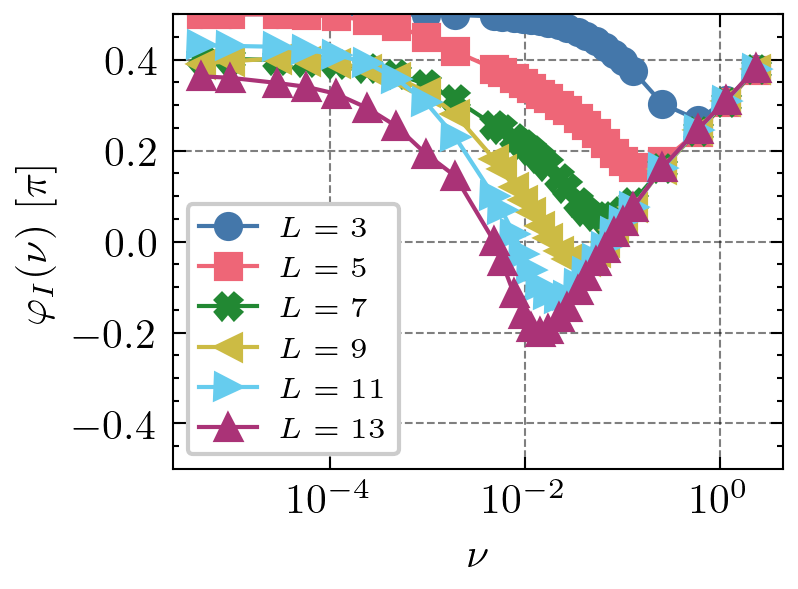

In [97]:
fig     = plt.figure(dpi=300)
ax      = fig.add_subplot()
w, h    = fig.get_size_inches()
scale   = 0.75
fig.set_size_inches(w * scale, h * scale)
for i, N in enumerate(N_PARTICLES):
    _   = ax.plot(np.array(FREQ_LIST_MHZ)/F0_SET, phase_I_d[N], marker=marker[i], label=rf'$L = {N}$')

_ = ax.set_xscale('log')
_ = ax.set_xlabel("$\\nu$")
_ = ax.set_ylabel("$\\varphi_{I}(\\nu)~[\mathrm{\pi}]$")
_ = ax.legend(fontsize='x-small', loc='lower left', ncol=1)
_ = ax.set_ylim(-0.5,0.5)
# _ = ax.set_xlim(1e-4,1e0)
# _ = plt.axvline(np.array(FREQ_LIST_MHZ)[12]/F0_SET)
# print(np.array(FREQ_LIST_MHZ)[12])

fig.savefig(f"plots/pdf/I_d_f0_phase_scaling.pdf", transparent=False)
fig.savefig(f"plots/svg/I_d_f0_phase_scaling.svg", transparent=True)
fig.savefig(f"plots/png/I_d_f0_phase_scaling.png", transparent=False)

### THD and Centroid

In [94]:
def compute_spectral_centroid(amplitudes, harmonic_orders, exclude_fundamental=True):
    """
    Calculates the Spectral Centroid (Center of Mass of the Harmonic Spectrum).
    
    Formula: C = Sum(n * A_n^2) / Sum(A_n^2)
    (Weighted by Power, consistent with energy distribution)
    
    Parameters:
    - amplitudes: Array of magnitudes [A_1, A_3, A_5...]
    - harmonic_orders: Array of harmonic indices [1, 3, 5...]
    - exclude_fundamental: If True, calculates the centroid of the DISTORTION only (n > 1).
                           If False, includes the fundamental frequency.
    
    Returns:
    - centroid: The weighted average harmonic order (e.g., 3.5 means energy is between n=3 and n=5).
    """
    # Ensure inputs are numpy arrays
    amps = np.asarray(amplitudes)
    ords = np.asarray(harmonic_orders)
    
    # 1. Filter: Decide whether to include n=1
    if exclude_fundamental:
        # Only keep harmonics where n > 1
        mask = ords > 1
        valid_amps = amps[mask]
        valid_ords = ords[mask]
    else:
        valid_amps = amps
        valid_ords = ords
        
    # 2. Calculate Power (Square of Amplitude)
    power = valid_amps**2
    total_power = np.sum(power)
    
    # 3. Safety Check for Zero Distortion
    if total_power < 1e-20:
        return np.nan # No harmonic energy exists
        
    # 4. Calculate Centroid
    # Sum(n * Power) / Sum(Power)
    centroid = np.sum(valid_ords * power) / total_power
    
    return centroid

def compute_thd(amplitudes):
    """
    Calculates Total Harmonic Distortion (THD).
    Input: Array of amplitudes [A_fund, A_harm1, A_harm2, ...]
    """
    if len(amplitudes) < 2 or amplitudes[0] == 0:
        return 0.0
        
    power_fund = amplitudes[0]**2
    power_harm = np.sum(amplitudes[1:]**2)
    
    return np.sqrt(power_harm) / np.sqrt(power_fund)

In [102]:
n_vals   = np.arange(1,8)
n_boot   = 100
thd_vals = {N : [[compute_thd(extract_harmonic_features(y[N][freq]+np.random.normal(0,y_e[N][freq]/1.96),n_vals,mode='abs',pad_len=4096)) for _ in range(n_boot)] for freq in FREQ_LIST_MHZ] for N in N_PARTICLES}
cf_vals  = {N : [[compute_spectral_centroid(extract_harmonic_features(y[N][freq]+np.random.normal(0,y_e[N][freq]/1.96),n_vals,mode='abs',pad_len=4096),n_vals,False) for _ in range(n_boot)] for freq in FREQ_LIST_MHZ] for N in N_PARTICLES}

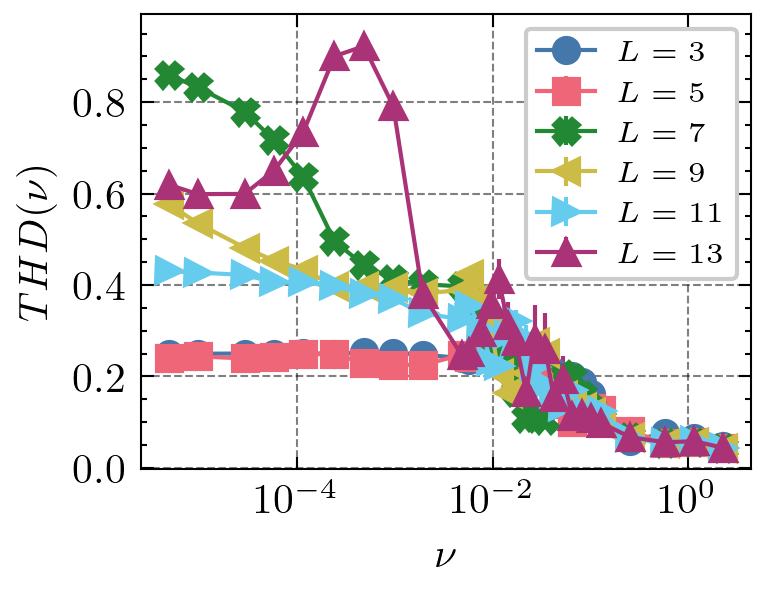

In [99]:
fig     = plt.figure(dpi=300)
ax      = fig.add_subplot()
w, h    = fig.get_size_inches()
scale   = 0.75
fig.set_size_inches(w * scale, h * scale)
for i, N in enumerate(N_PARTICLES):
    _   = ax.errorbar(x=np.array(FREQ_LIST_MHZ)/F0_SET, y=np.mean(thd_vals[N],axis=1), yerr=np.std(thd_vals[N],axis=1), marker=marker[i], label=rf'$L = {N}$')

_ = ax.set_xscale('log')
_ = ax.set_xlabel("$\\nu$")
_ = ax.set_ylabel("$THD(\\nu)$")
_ = ax.legend(fontsize='x-small', loc='upper right', ncol=1)
# _ = ax.set_ylim(0,0.5)
# _ = ax.set_xlim(1e-4,1e0)

fig.savefig(f"plots/pdf/THD_scaling.pdf", transparent=False)
fig.savefig(f"plots/svg/THD_scaling.svg", transparent=True)
fig.savefig(f"plots/png/THD_scaling.png", transparent=False)

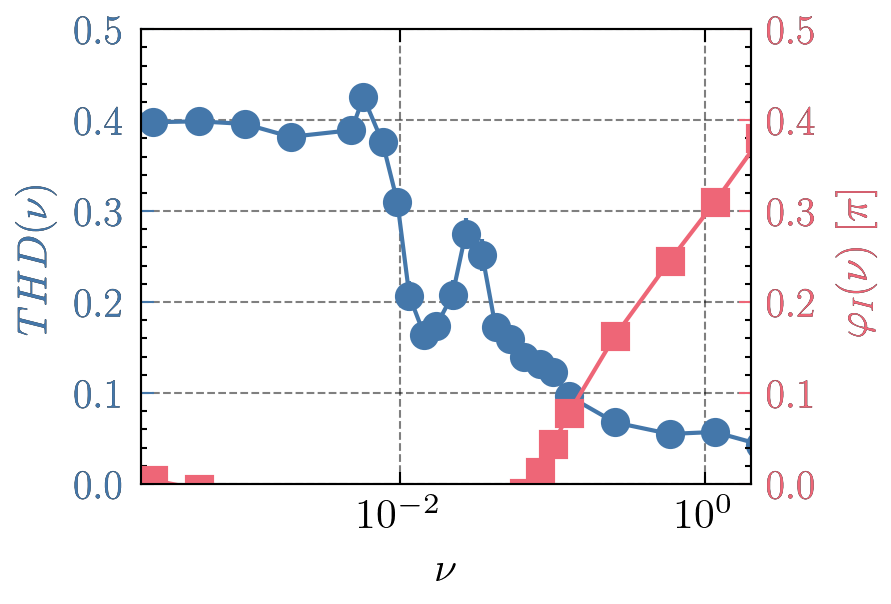

In [100]:
import matplotlib.patheffects as pe

fig     = plt.figure(dpi=300)
ax      = fig.add_subplot()
ax2     = ax.twinx()
w, h    = fig.get_size_inches()
scale   = 0.75
fig.set_size_inches(w * scale, h * scale)
_   = ax.errorbar(x=np.array(FREQ_LIST_MHZ)/F0_SET, y=np.mean(thd_vals[9],axis=1), yerr=np.std(thd_vals[9],axis=1), color=BLUE_COLOR, marker='o')
_   = ax2.plot(np.array(FREQ_LIST_MHZ)/F0_SET, phase_I[9], color=RED_COLOR, marker='s')
    
_ = ax.set_xscale('log')
_ = ax.set_xlabel("$\\nu$")
_ = ax.set_ylim(0,0.5)
_ = ax2.set_ylim(0,0.5)
_ = ax.set_xlim(2e-4,2e-0)
_ = ax2.grid(False)

l0 = ax.set_ylabel("$THD(\\nu)$", color=BLUE_COLOR)
l1 = ax2.set_ylabel("$\\varphi_{I}(\\nu)~[\mathrm{\pi}]$", color=RED_COLOR)
l0.set_path_effects([pe.Stroke(linewidth=0.1, foreground='black'),pe.Normal()])
l1.set_path_effects([pe.Stroke(linewidth=0.1, foreground='black'),pe.Normal()])

ax.tick_params(axis='y', colors=BLUE_COLOR)
ax2.tick_params(axis='y', colors=RED_COLOR)
for lbl in ax.get_yticklabels():
    lbl.set_path_effects([pe.Stroke(linewidth=0.1, foreground='black'),pe.Normal()])
for lbl in ax2.get_yticklabels():
    lbl.set_path_effects([pe.Stroke(linewidth=0.1, foreground='black'),pe.Normal()])

# fig.savefig(f"plots/pdf/THD_vs_phase_vs_freq.pdf", transparent=False)
# fig.savefig(f"plots/svg/THD_vs_phase_vs_freq.svg", transparent=True)
# fig.savefig(f"plots/png/THD_vs_phase_vs_freq.png", transparent=False)

### Linear vs Simulation

In [120]:
def get_potential_phasor(L: int, omega: float, U_phasor: np.ndarray, N_e: int = 8):
    topo = {"Nx": L,"Ny": L,
            "e_pos": [[(L-1)//2, 0],[0, 0],[L-1, 0],
                    [0, (L-1)//2],[L-1, (L-1)//2],
                    [0, L-1],[L-1, L-1],[(L-1)//2, L-1]],
            "electrode_type": ['constant']*N_e}
    sim  = Simulation(topo)
    sim.build_conductance_matrix()
    G     = sim.get_conductance_matrix()
    G_mat = G[:-N_e,:-N_e]
    G_u   = G[:-N_e,-N_e:]
    C_mat = sim.get_capacitance_matrix()*1e-18
    C_u   = sim.get_electrode_capacitance_matrix().T*1e-18
    Y     = G_mat + C_mat*omega*1j
    I_ext = -(G_u + C_u*omega*1j)@U_phasor
    return np.linalg.solve(Y, I_ext)

def get_current_phasor(L: int, omega: float, U_phasor: np.ndarray, N_e: int = 8):
    topo = {"Nx": L,"Ny": L,
            "e_pos": [[(L-1)//2, 0],[0, 0],[L-1, 0],
                    [0, (L-1)//2],[L-1, (L-1)//2],
                    [0, L-1],[L-1, L-1],[(L-1)//2, L-1]],
            "electrode_type": ['constant']*N_e}
    sim  = Simulation(topo)
    sim.build_conductance_matrix()
    G     = sim.get_conductance_matrix()
    G_mat = G[:-N_e,:-N_e]
    G_u   = G[:-N_e,-N_e:]
    C_mat = sim.get_capacitance_matrix()*1e-18
    C_u   = sim.get_electrode_capacitance_matrix().T*1e-18
    Y     = G_mat + C_mat*omega*1j
    I_ext = -(G_u + C_u*omega*1j)@U_phasor

    idx         = np.where(G_u[:, -1] != 0)[0][0]
    phi_phasor  = np.linalg.solve(Y, I_ext)
    node_pot    = phi_phasor[idx,0]

    Y_idx = G_u[idx, -1] + 1j * omega * C_u[idx, -1]
    I_idx = Y_idx * node_pot

    return I_idx

gain_p_theory = {}
gain_I_theory = {}
for N in N_PARTICLES:
        U_phasor = np.array([0.02,0,0,0,0,0,0,0])[:,np.newaxis]

        phi_phasor = np.mean(np.array([get_potential_phasor(N, 2*np.pi*freq*1e6, U_phasor).flatten() for freq in FREQ_LIST_MHZ+[4800,9600]]),axis=1)
        gain_arg = np.abs(phi_phasor / phi_phasor[0])
        gain_phi = 20*np.log10(gain_arg)
        gain_p_theory[N] = gain_phi

        I_phasor = np.array([get_current_phasor(N, 2*np.pi*freq*1e6, U_phasor).flatten() for freq in FREQ_LIST_MHZ+[4800,9600]])
        gain_arg = np.abs(I_phasor / I_phasor[0])
        gain_cur = 20*np.log10(gain_arg)
        gain_I_theory[N] = gain_cur

In [144]:
n_handles

[[<matplotlib.lines.Line2D at 0x7542c15f8f10>],

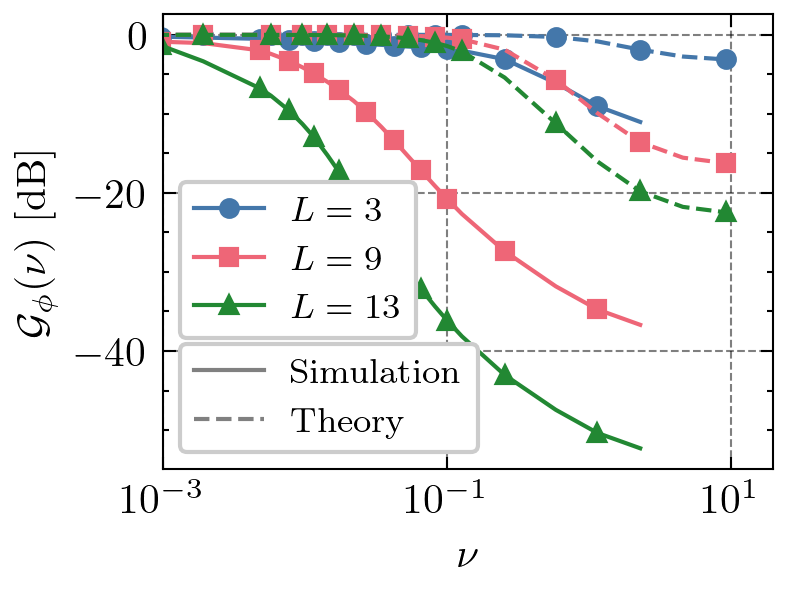

In [149]:
from matplotlib.lines import Line2D

fig     = plt.figure(dpi=300)
ax      = fig.add_subplot()
w, h    = fig.get_size_inches()
scale   = 0.75
markers = ['o','s','^']
fig.set_size_inches(w * scale, h * scale)

# We'll store handles for the 'N' legend here
n_handles = []

for i, N in enumerate([3, 9, 13]):
    freqs = np.array(FREQ_LIST_MHZ) / F0_SET
    freqs_theory = np.array(FREQ_LIST_MHZ + [4800, 9600]) / F0_SET
    
    # 1. Simulation (Solid)
    line, = ax.plot(freqs, np.mean(gain_p[N],axis=1), marker=markers[i], ms=4, 
                    markevery=(1, 2), label=f'$L = {N}$')
    n_handles.append(line) # Save this for the first legend
    
    # 2. Theory (Dashed)
    ax.plot(freqs_theory, gain_p_theory[N], color=line.get_color(), 
            ls='--', marker=markers[i], ms=4, markevery=2)

# --- Legend 1: System Size (N) ---
# We use the handles we collected in the loop
leg1 = ax.legend(handles=n_handles, loc='lower left', fontsize='small', bbox_to_anchor=(0,0.25))
ax.add_artist(leg1) # This is the magic trick to keep the first legend from being deleted

# --- Legend 2: Simulation vs Theory ---
# We create "Proxy Artists" that only define the line style
style_handles = [
    Line2D([0], [0], color='gray', ls='-', label='Simulation'),
    Line2D([0], [0], color='gray', ls='--', label='Theory')
]
leg2 = ax.legend(handles=style_handles, loc='lower left', fontsize='small')

_ = ax.set_xscale('log')
_ = ax.set_xlabel("$\\nu$")
_ = ax.set_xlim(1e-3, 2e1)
_ = ax.set_ylabel("$\mathcal{G}_\phi(\\nu)$ [dB]")

# fig.savefig(f"plots/pdf/pot_f0_gain_theory_vs_sim.pdf", transparent=False)
# fig.savefig(f"plots/svg/pot_f0_gain_theory_vs_sim.svg", transparent=True)
# fig.savefig(f"plots/png/pot_f0_gain_theory_vs_sim.png", transparent=False)

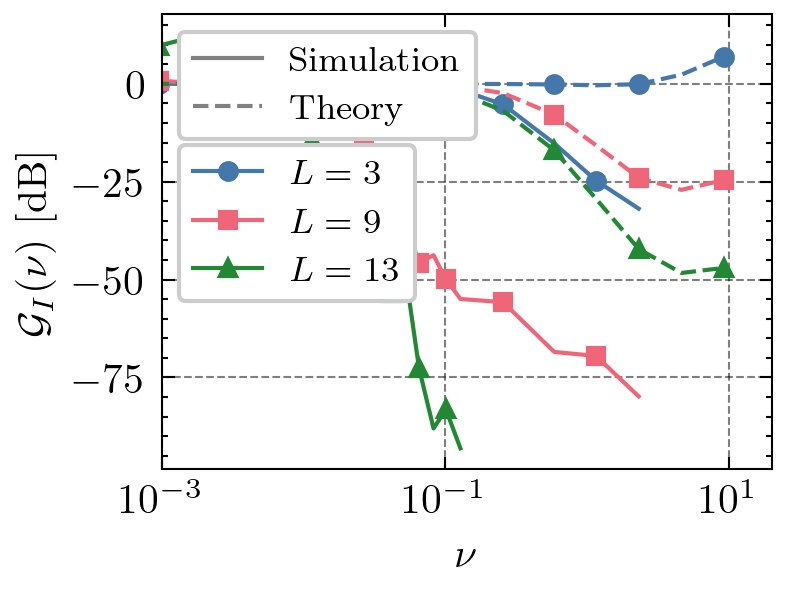

In [150]:
from matplotlib.lines import Line2D

fig     = plt.figure(dpi=300)
ax      = fig.add_subplot()
w, h    = fig.get_size_inches()
scale   = 0.75
markers = ['o','s','^']
fig.set_size_inches(w * scale, h * scale)

# We'll store handles for the 'N' legend here
n_handles = []

for i, N in enumerate([3, 9, 13]):
    freqs = np.array(FREQ_LIST_MHZ) / F0_SET
    freqs_theory = np.array(FREQ_LIST_MHZ + [4800, 9600]) / F0_SET
    
    # 1. Simulation (Solid)
    line, = ax.plot(freqs, np.mean(gain_I[N],axis=1), marker=markers[i], ms=4, 
                    markevery=(1, 2), label=f'$L = {N}$')
    n_handles.append(line) # Save this for the first legend
    
    # 2. Theory (Dashed)
    ax.plot(freqs_theory, gain_I_theory[N], color=line.get_color(), 
            ls='--', marker=markers[i], ms=4, markevery=2)

# --- Legend 1: System Size (N) ---
# We use the handles we collected in the loop
leg1 = ax.legend(handles=n_handles, loc='upper left', bbox_to_anchor=(0,0.75), fontsize='small')
ax.add_artist(leg1) # This is the magic trick to keep the first legend from being deleted

# --- Legend 2: Simulation vs Theory ---
# We create "Proxy Artists" that only define the line style
style_handles = [
    Line2D([0], [0], color='gray', ls='-', label='Simulation'),
    Line2D([0], [0], color='gray', ls='--', label='Theory')
]
leg2 = ax.legend(handles=style_handles, loc='upper left', fontsize='small')

_ = ax.set_xscale('log')
_ = ax.set_xlabel("$\\nu$")
_ = ax.set_xlim(1e-3, 2e1)
_ = ax.set_ylabel("$\mathcal{G}_I(\\nu)$ [dB]")

# fig.savefig(f"plots/pdf/I_f0_gain_theory_vs_sim.pdf", transparent=False)
# fig.savefig(f"plots/svg/I_f0_gain_theory_vs_sim.svg", transparent=True)
# fig.savefig(f"plots/png/I_f0_gain_theory_vs_sim.png", transparent=False)

### Memory Capacity (does not really make sense here)

In [48]:
def memory_capacity(x: np.ndarray, u: np.ndarray, lags: np.ndarray) -> tuple[float, np.ndarray]:
    """
    Calculates the Linear Memory Capacity (MC) analytically using covariance matrices.
    
    This measures how much information about the past input u(t-k) is contained 
    linearly within the reservoir state x(t). It is equivalent to the R^2 score 
    of an optimally trained linear readout for each lag.

    Parameters:
    -----------
    x : np.ndarray
        State matrix of shape (steps, N_nodes). 
        Can be Potentials (recommended) or Charges.
    u : np.ndarray
        Input signal of shape (steps,).
    lags : np.ndarray or list
        Integer delays k to evaluate (e.g., np.arange(1, 100)).

    Returns:
    --------
    total_mc : float
        Sum of MC over all provided lags.
    mc_k : np.ndarray
        The specific MC values for each lag.
    """
    
    # 1. Preprocessing: Center the data (Remove Mean)
    # We ignore the intercept term by centering, which simplifies the math.
    X_centered = x - np.mean(x, axis=0)
    u_centered = u - np.mean(u)
    
    T = X_centered.shape[0]
    
    # 2. Compute State Covariance Matrix (Sigma_X)
    # Shape: (N, N)
    Sigma_X = (X_centered.T @ X_centered) / (T - 1)
    
    # 3. Compute Pseudo-Inverse of Sigma_X
    # We use pinv (Pseudo-inverse) because if nodes are highly correlated 
    # (e.g., neighbors in a chain), the matrix is singular/ill-conditioned.
    Sigma_X_inv = np.linalg.pinv(Sigma_X)
    
    # 4. Variance of Input (Normalization factor)
    var_u = np.var(u_centered, ddof=1)
    
    mc_k = []
    
    for k in lags:
        if k == 0:
            # Zero lag is usually not considered "memory", but we can calc it.
            # No shifting needed.
            u_shifted = u_centered
            valid_indices = slice(None)
        else:
            # Shift input back by k steps: u(t-k)
            # We must truncate the arrays to align valid data points.
            # x[k:] corresponds to u[0:-k] (which represents u at t-k)
            u_shifted = u_centered[:-k]
            X_truncated = X_centered[k:]
            
            # Recalculate covariances for the truncated segment to be exact
            # (Or assume stationarity and use full X. Truncation is safer for short series.)
            # Cross-Covariance p_k = Cov(x(t), u(t-k))
            p_k = (X_truncated.T @ u_shifted) / (len(u_shifted) - 1)
            
            # 5. Calculate MC_k
            # Formula: p_k.T @ Sigma_inv @ p_k / var(u)
            # This is mathematically identical to the R^2 of a linear regression.
            score = (p_k.T @ Sigma_X_inv @ p_k) / var_u
            
            # R^2 cannot theoretically exceed 1.0, but numerical noise might cause 1.000001
            score = min(score, 1.0)
            mc_k.append(score)

    mc_k = np.array(mc_k)
    total_mc = np.sum(mc_k)
    
    return total_mc, mc_k

In [80]:
n_per       = 10
lags        = np.arange(1, SAMPLE_P_PERIOD*n_per)
mc_s        = {N : [memory_capacity(p[N][freq],x[N][freq],lags)[0] for freq in FREQ_LIST_MHZ] for N in N_PARTICLES}
mc_I        = {N : [memory_capacity(y[N][freq][:,np.newaxis],x[N][freq],lags)[0] for freq in FREQ_LIST_MHZ] for N in N_PARTICLES}
mc_s_vs_lag = {N : {freq : memory_capacity(p[N][freq],x[N][freq],lags) for freq in FREQ_LIST_MHZ} for N in N_PARTICLES}
mc_I_vs_lag = {N : {freq : memory_capacity(y[N][freq][:,np.newaxis],x[N][freq],lags) for freq in FREQ_LIST_MHZ} for N in N_PARTICLES}

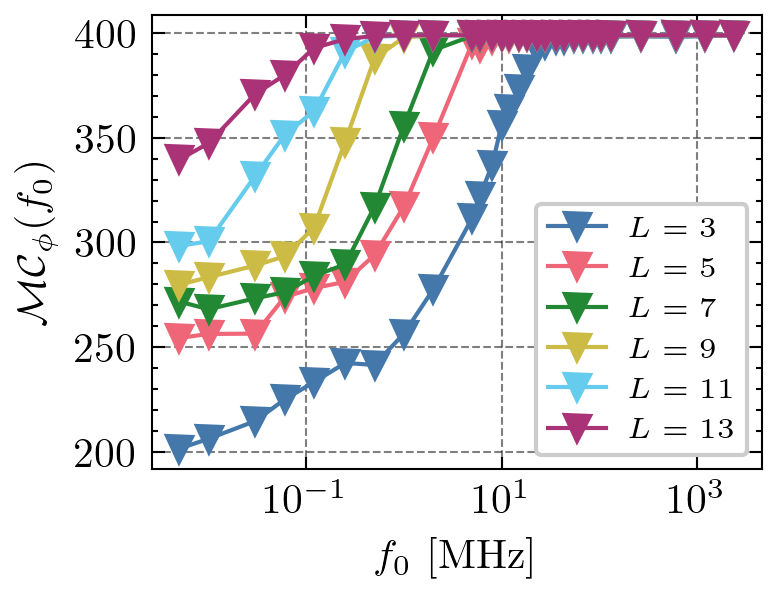

In [ ]:
fig     = plt.figure(dpi=300)
ax      = fig.add_subplot()
w, h    = fig.get_size_inches()
scale   = 0.75
fig.set_size_inches(w * scale, h * scale)
for N in N_PARTICLES:
    _   = ax.plot(FREQ_LIST_MHZ, mc_s[N], marker=marker[i], label=rf'$L = {N}$')

_ = ax.set_xscale('log')
_ = ax.set_xlabel("$f_0$ [MHz]")
_ = ax.set_ylabel("$\mathcal{MC}_{\phi}(f_0)$")
_ = ax.legend(fontsize='x-small', loc='lower right', ncol=1)

# fig.savefig(f"plots/pdf/pot_f0_MC_scaling.pdf", transparent=False)
# fig.savefig(f"plots/svg/pot_f0_MC_scaling.svg", transparent=True)
# fig.savefig(f"plots/png/pot_f0_MC_scaling.png", transparent=False)

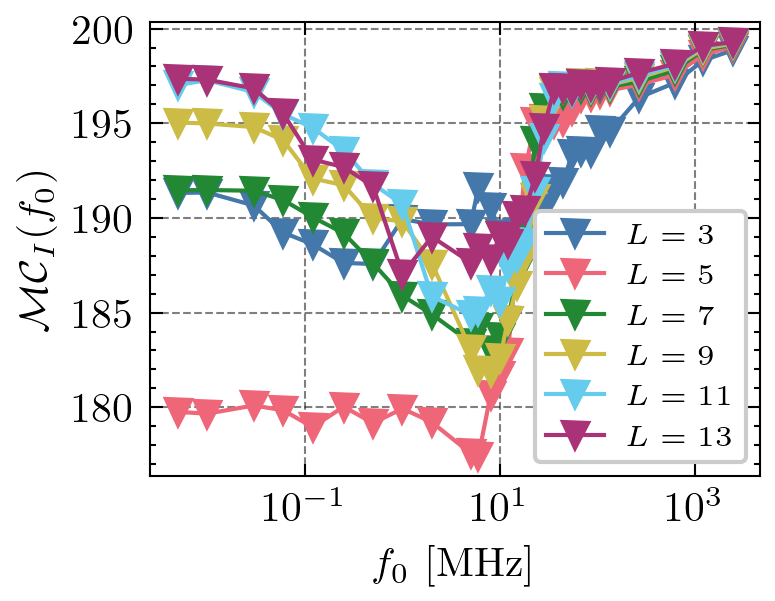

In [ ]:
fig     = plt.figure(dpi=300)
ax      = fig.add_subplot()
w, h    = fig.get_size_inches()
scale   = 0.75
fig.set_size_inches(w * scale, h * scale)
for N in N_PARTICLES:
    _   = ax.plot(FREQ_LIST_MHZ, mc_I[N], marker=marker[i], label=rf'$L = {N}$')

_ = ax.set_xscale('log')
_ = ax.set_xlabel("$f_0$ [MHz]")
_ = ax.set_ylabel("$\mathcal{MC}_{I}(f_0)$")
_ = ax.legend(fontsize='x-small', loc='lower right', ncol=1)

# fig.savefig(f"plots/pdf/I_f0_MC_scaling.pdf", transparent=False)
# fig.savefig(f"plots/svg/I_f0_MC_scaling.svg", transparent=True)
# fig.savefig(f"plots/png/I_f0_MC_scaling.png", transparent=False)

### Spatial Distribution

In [119]:
N_NP     = 13
topo = {"Nx": N_NP,"Ny": N_NP, "e_pos": [[(N_NP-1)//2, 0],[0, 0],[N_NP-1, 0],
               [0, (N_NP-1)//2],[N_NP-1, (N_NP-1)//2],[0, N_NP-1],
               [N_NP-1, N_NP-1],[(N_NP-1)//2, N_NP-1]],
            "electrode_type": ['constant']*8}
sim_class   = Simulation(topo)
G_obj       = sim_class.get_graph()
pos         = sim_class.get_positions()
pos         = {(key+8 if key >= 0 else (abs(key)-1)) : (val) for key, val in pos.items()}
E_CHARGE    = sim_class.ELE_CHARGE_A_C
CAP_MAT     = sim_class.get_capacitance_matrix()
t_points = [0,int(0.25*SAMPLE_P_PERIOD),int(0.5*SAMPLE_P_PERIOD),int(0.75*SAMPLE_P_PERIOD)]
phi_vecs = {}
q_vecs   = {}
t_vecs   = {}
x_vecs   = {}
y_vecs   = {}

for freq in FREQ_LIST_MHZ:

    t       = time[freq][:-1][:-N_SKIP*SAMPLE_P_PERIOD]*1e9
    phi_vec = p_s[N_NP][freq]
    q_vec   = (CAP_MAT @ phi_vec.T).T/E_CHARGE

    phi_vecs[freq]  = phi_vec.copy()
    q_vecs[freq]    = q_vec.copy()
    t_vecs[freq]    = t.copy()
    x_vecs[freq]    = x.copy()
    y_vecs[freq]    = y.copy()

In [120]:
def analyze_lattice_with_moments(arr: np.ndarray):
    """
    Analyzes the full 2D lattice using a model-free moment-based approach on projected profiles.

    Calculates the "center of charge" (mean) and "charge spread" (RMS width)
    for the FULL distribution projected onto the horizontal (x) and vertical (y) axes.

    Args:
        arr (np.ndarray): A 9x9 NumPy array of the lattice state (charge or potential).

    Returns:
        Tuple[float, float, float, float]: A tuple containing:
            - mean_x (float): The center of charge along the x-axis.
            - width_x (float): The RMS spread of charge along the x-axis (Lateral Spread).
            - mean_y (float): The center of charge along the y-axis (Penetration Depth).
            - width_y (float): The RMS spread of charge along the y-axis (Longitudinal Spread).
    """
    ny, nx = arr.shape
    x_coords = np.arange(nx)
    y_coords = np.arange(ny)

    # Use absolute values as weights (magnitude of excitation)
    weights = np.abs(arr)
    total_weight = np.sum(weights)

    # Avoid division by zero if there's no charge
    if total_weight == 0:
        return np.nan, np.nan, np.nan, np.nan

    # --- 1. Project 2D Data to 1D Axes ---
    # Instead of taking a single slice, we SUM over the perpendicular axis.
    # This captures charge moving in the "wings," not just the center line.
    profile_x = np.sum(weights, axis=0)  # Sum columns to get X distribution
    profile_y = np.sum(weights, axis=1)  # Sum rows to get Y distribution

    # --- 2. Calculate Moments for X ---
    # Mean position X
    mean_x = np.sum(x_coords * profile_x) / total_weight
    
    # RMS width X
    var_x = np.sum(((x_coords - mean_x)**2) * profile_x) / total_weight
    width_x = np.sqrt(var_x)

    # --- 3. Calculate Moments for Y ---
    # Mean position Y
    mean_y = np.sum(y_coords * profile_y) / total_weight
    
    # RMS width Y
    var_y = np.sum(((y_coords - mean_y)**2) * profile_y) / total_weight
    width_y = np.sqrt(var_y)

    return mean_x, width_x, mean_y, width_y

N_samples   = 20
q_c_max     = []
q_c_zero    = []
phi_c_max   = []
phi_c_zero  = []
charge      = True

for freq in FREQ_LIST_MHZ:
    vals = [analyze_lattice_with_moments(q_vecs[freq][i*SAMPLE_P_PERIOD].copy().reshape(N_NP,N_NP)) for i in range(N_samples)]
    q_c_zero.append(vals)

    vals = [analyze_lattice_with_moments(q_vecs[freq][i*SAMPLE_P_PERIOD + int(0.25*SAMPLE_P_PERIOD)].copy().reshape(N_NP,N_NP)) for i in range(N_samples)]
    q_c_max.append(vals)

    vals = [analyze_lattice_with_moments(phi_vecs[freq][i*SAMPLE_P_PERIOD].copy().reshape(N_NP,N_NP)) for i in range(N_samples)]
    phi_c_zero.append(vals)

    vals = [analyze_lattice_with_moments(phi_vecs[freq][i*SAMPLE_P_PERIOD + int(0.25*SAMPLE_P_PERIOD)].copy().reshape(N_NP,N_NP)) for i in range(N_samples)]
    phi_c_max.append(vals)

if charge:
    mean_x_max  = np.array([[q_c_max[i][j][0] for j in range(N_samples)] for i in range(len(FREQ_LIST_MHZ))])
    width_x_max = np.array([[q_c_max[i][j][1] for j in range(N_samples)] for i in range(len(FREQ_LIST_MHZ))])
    mean_y_max  = np.array([[q_c_max[i][j][2] for j in range(N_samples)] for i in range(len(FREQ_LIST_MHZ))])
    width_y_max = np.array([[q_c_max[i][j][3] for j in range(N_samples)] for i in range(len(FREQ_LIST_MHZ))])

    mean_x_zero     = np.array([[q_c_zero[i][j][0] for j in range(N_samples)] for i in range(len(FREQ_LIST_MHZ))])
    width_x_zero    = np.array([[q_c_zero[i][j][1] for j in range(N_samples)] for i in range(len(FREQ_LIST_MHZ))])
    mean_y_zero     = np.array([[q_c_zero[i][j][2] for j in range(N_samples)] for i in range(len(FREQ_LIST_MHZ))])
    width_y_zero    = np.array([[q_c_zero[i][j][3] for j in range(N_samples)] for i in range(len(FREQ_LIST_MHZ))])
else:
    mean_x_max  = np.array([[phi_c_max[i][j][0] for j in range(N_samples)] for i in range(len(FREQ_LIST_MHZ))])
    width_x_max = np.array([[phi_c_max[i][j][1] for j in range(N_samples)] for i in range(len(FREQ_LIST_MHZ))])
    mean_y_max  = np.array([[phi_c_max[i][j][2] for j in range(N_samples)] for i in range(len(FREQ_LIST_MHZ))])
    width_y_max = np.array([[phi_c_max[i][j][3] for j in range(N_samples)] for i in range(len(FREQ_LIST_MHZ))])

    mean_x_zero     = np.array([[phi_c_zero[i][j][0] for j in range(N_samples)] for i in range(len(FREQ_LIST_MHZ))])
    width_x_zero    = np.array([[phi_c_zero[i][j][1] for j in range(N_samples)] for i in range(len(FREQ_LIST_MHZ))])
    mean_y_zero     = np.array([[phi_c_zero[i][j][2] for j in range(N_samples)] for i in range(len(FREQ_LIST_MHZ))])
    width_y_zero    = np.array([[phi_c_zero[i][j][3] for j in range(N_samples)] for i in range(len(FREQ_LIST_MHZ))])

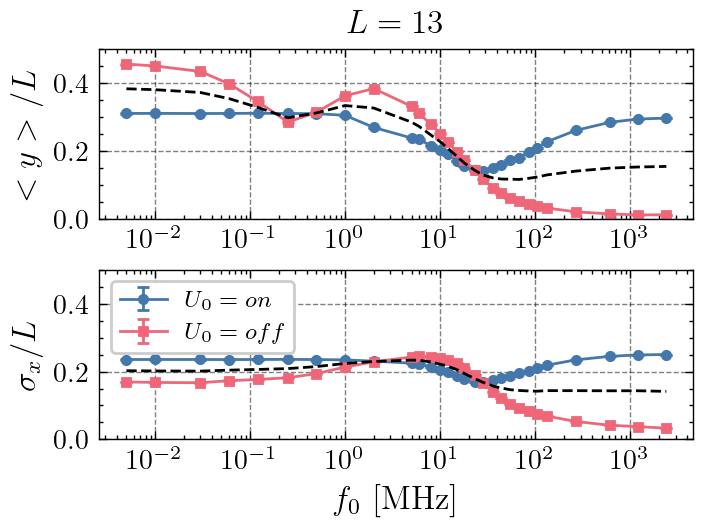

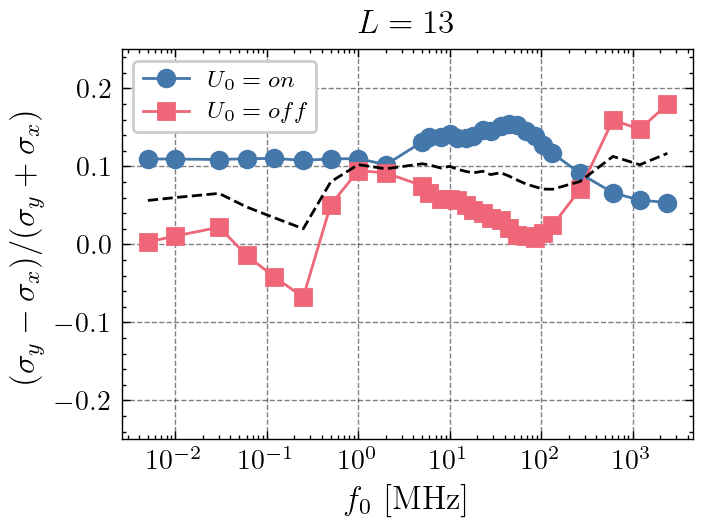

In [121]:
fig = plt.figure(dpi=200, layout='constrained')
ax  = fig.add_subplot(2,1,1)
ax.errorbar(FREQ_LIST_MHZ, np.mean(mean_y_max,axis=1)/N_NP, 1.95*np.std(mean_y_max,axis=1)/(N_NP*np.sqrt(N_samples)), marker='o', capsize=2, label='$U_0 = on$', ms=3)
ax.errorbar(FREQ_LIST_MHZ, np.mean(mean_y_zero,axis=1)/N_NP, 1.95*np.std(mean_y_zero,axis=1)/(N_NP*np.sqrt(N_samples)), marker='s', capsize=2, label='$U_0 = off$', ms=3)
ax.plot(FREQ_LIST_MHZ, (np.mean(mean_y_max,axis=1)+np.mean(mean_y_zero,axis=1))/(2*N_NP), '--', color='black', zorder=10)
_ = ax.set_title(f"$L = {N_NP}$")
_ = ax.set_ylabel("$<y> / L$", fontsize='large')
_ = ax.set_xscale('log')
_ = ax.set_ylim(0,0.5)
ax = fig.add_subplot(2,1,2)
ax.errorbar(FREQ_LIST_MHZ, np.mean(width_x_max,axis=1)/N_NP, 1.95*np.std(width_x_max,axis=1)/(N_NP*np.sqrt(N_samples)), marker='o', capsize=2, label='$U_0 = on$', ms=3)
ax.errorbar(FREQ_LIST_MHZ, np.mean(width_x_zero,axis=1)/N_NP, 1.95*np.std(width_x_zero,axis=1)/(N_NP*np.sqrt(N_samples)), marker='s', capsize=2, label='$U_0 = off$', ms=3)
ax.plot(FREQ_LIST_MHZ, (np.mean(width_x_max,axis=1)+np.mean(width_x_zero,axis=1))/(2*N_NP), '--', color='black', zorder=10)
_ = ax.set_xscale('log')
_ = ax.set_ylim(0,0.5)
_ = ax.set_xlabel("$f_0$ [MHz]", fontsize='large')
_ = ax.set_ylabel("$\sigma_x / L$", fontsize='large')
_ = ax.legend(fontsize='small', loc='upper left')

if charge:
    fig.savefig(f"plots/svg/charge_penetration_{N_NP}.svg", transparent=True)
    fig.savefig(f"plots/pdf/charge_penetration_{N_NP}.pdf", transparent=False)
    fig.savefig(f"plots/png/charge_penetration_{N_NP}.png", transparent=False)
else:
    fig.savefig(f"plots/svg/pot_penetration_{N_NP}.svg", transparent=True)
    fig.savefig(f"plots/pdf/pot_penetration_{N_NP}.pdf", transparent=False)
    fig.savefig(f"plots/png/pot_penetration_{N_NP}.png", transparent=False)

fig = plt.figure(dpi=200, layout='constrained')
ax  = fig.add_subplot()
ax.plot(FREQ_LIST_MHZ, (np.mean(width_y_max,axis=1)-np.mean(width_x_max,axis=1))/(np.mean(width_y_max,axis=1)+np.mean(width_x_max,axis=1)),'-o', label='$U_0 = on$')
ax.plot(FREQ_LIST_MHZ, (np.mean(width_y_zero,axis=1)-np.mean(width_x_zero,axis=1))/(np.mean(width_y_zero,axis=1)+np.mean(width_x_zero,axis=1)),'-s', label='$U_0 = off$')
ax.plot(FREQ_LIST_MHZ, ((np.mean(width_y_max,axis=1)-np.mean(width_x_max,axis=1))/(np.mean(width_y_max,axis=1)+np.mean(width_x_max,axis=1))+
                        (np.mean(width_y_zero,axis=1)-np.mean(width_x_zero,axis=1))/(np.mean(width_y_zero,axis=1)+np.mean(width_x_zero,axis=1)))/2, '--', color='black', zorder=10)
# _ = ax.set_title(f"$U_0 = {amp*1000}$ mV")
_ = ax.set_ylabel("$(\sigma_y-\sigma_x)/(\sigma_y+\sigma_x)$", fontsize='large')
_ = ax.set_xlabel("$f_0$ [MHz]", fontsize='large')
_ = ax.set_xscale('log')
_ = ax.set_title(f"$L = {N_NP}$")
_ = ax.set_ylim(-0.25,0.25)
_ = ax.legend(fontsize='small', loc='upper left')
if charge:
    fig.savefig(f"plots/svg/charge_anisotropy_{N_NP}.svg", transparent=True)
    fig.savefig(f"plots/pdf/charge_anisotropy_{N_NP}.pdf", transparent=False)
    fig.savefig(f"plots/png/charge_anisotropy_{N_NP}.png", transparent=False)
else:
    fig.savefig(f"plots/svg/pot_anisotropy_{N_NP}.svg", transparent=True)
    fig.savefig(f"plots/pdf/pot_anisotropy_{N_NP}.pdf", transparent=False)
    fig.savefig(f"plots/png/pot_anisotropy_{N_NP}.png", transparent=False)